# Overview
This notebook was created to analyse the Airbnb dataset provided by the online data science platform Kaggle. The data can be found through the following [link](https://www.kaggle.com/datasets/mysarahmadbhat/airbnb-listings-reviews?sort=votes).  
Acquiring the data might require registering and logging in to the platform  
DISCLAIMER: The approach used in this notebook is mostly inspired by the following great [notebook](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)  

# Preliminary: Imports and loading data
Please make sure to have the dataset saved in the workding directory

In [365]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [366]:
# variable to determine whether the notebook is running on Collab or not
try:
  import google 
  IN_COLAB = True
except:
  IN_COLAB = False

In [367]:
import os
from zipfile import ZipFile

# # please save the data in sample_data folder if the notebook is running on google colab
# DOWNLOAD_DIR = "sample_data" if IN_COLAB else os.getcwd() 
# file_name = "archive.zip"
# file_name_no_zip = "archive"
# loc = os.path.join(DOWNLOAD_DIR, file_name)
# # opening the zip file in READ mode

# if not os.path.isdir(os.path.join(DOWNLOAD_DIR, file_name_no_zip)):
#     with ZipFile(loc, 'r') as zip_ref:
#         zip_ref.extractall()
#         print('Done!')


In [368]:
from copy import copy
# the relevant datasets are Listings.csv and Reviews.csv

listings_loc = os.path.join(os.getcwd(), 'final_listings_temp.csv')
# reviews_loc = os.path.join(os.getcwd(), "data",'Reviews.csv')

#retrieve the data
ls = pd.read_csv(listings_loc,  encoding='latin1')
# revs = pd.read_csv(reviews_loc, encoding='latin1')

ls_org = copy(ls) # keeping a copy of the original dataset
# revs_org = copy(revs) # keeping copy of the original dataset for further use

C:\Users\bouab\AppData\Local\Temp\ipykernel_376\1419513362.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ls = pd.read_csv(listings_loc,  encoding='latin1')


In [369]:
ls.columns

Index(['listing_id', 'name', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'district', 'city', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'scores', 'date', 'comments'],
      dtype='object')

# Helper functions
In this subsection, I write a number of functions that I will use across the jupyter notebook

In [370]:
def get_col_types(df: pd.DataFrame, nunique_as_discrete=20):
    # select all numerical features 
    num_cols = set(list(df.select_dtypes(np.number).columns))
    # any feature that is non-numerical is selected as categorical
    cat_cols = set([c for c in df.columns if c not in num_cols])
    
    # let's further filter the numerical features: those with a small number of unique values are considered categorical
    discrete_num_cols = [col for col in num_cols if len(df.value_counts(col)) <= nunique_as_discrete]
    # add them to the categorical features
    cat_cols.update(discrete_num_cols)
    # update the numerical features
    num_cols = num_cols.difference(cat_cols)
    return list(num_cols), list(cat_cols)

In [371]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

def draw_unique_data_table(df):
    nunique = pd.DataFrame(data=[], columns=['n_unique'])
    for c in df.columns:    
        nunique = pd.concat([nunique, pd.DataFrame({'n_unique': [len(df[c].value_counts())]}, index=[c])])
    return nunique


In [372]:
def map_values(df:pd.DataFrame, columns:list , cols_dicts:dict):
    """ This function will map certain values in each passed to another set of values. The mapping is defined by the cols_dicts
    """
    # first make sure all columns are part of the dataframe
    try:
        df.loc[:, columns] 
    except KeyError:
        print(f"PLEASE MAKE SURE THAT each column in {list(columns)} belongs to the passed dataframe")
    
    # make sure passing a string is acceptable
    if isinstance(columns, str):
        columns = [columns]
    
    # make sure passing a single dictionary is acceptable
    if isinstance(cols_dicts, dict):
        cols_dicts = [cols_dicts]

    # second make sure the lengths of both iterables are the same
    assert len(columns) == len(cols_dicts)

    # map the dictionary and the columns into a single dictionary
    replace_dictionary = dict(zip(columns, cols_dicts))
    # return the new dictionary
    return df.replace(to_replace=replace_dictionary)

In [373]:
def new_col_names(old_new_names, df):
    try:    
        df = df.rename(columns=old_new_names)
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        print(f"PLEASE MAKE SURE THAT each column in {df_no_col} is in the passed dataframe")
    return df

In [374]:
from empiricaldist import Cdf

def display_cdfs(data:pd.DataFrame, y:str, feat:str, feat_values:list=None, title:str=None):
   
    # if the values of the feature are not determined, then we consider all values
    if feat_values is None: 
        feat_values = list(data[feat].value_counts().index)
    
    # construct the conditional cdf of the target 'y' for each unique passed value of 'feat' 
    for v in feat_values:
        d = data[data[feat] == v][y]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=v)

    plt.legend()
    plt.xlabel(f'{y}')
    plt.ylabel(f'cdf of {feat}')
    plt.title((title if title is not None else f'cdf of {y} with respect to {feat}'))
    plt.show()   


In [375]:
def display_histogram(data, num_feat, cat_feat, figsize=None, title:str=None):
    if figsize is None:
        figsize = (10, 10)
    plt.figure(figsize=figsize)
    cat_unique = list(data.value_counts(cat_feat).index)
    for v in cat_unique:
        plt.hist(data[data[cat_feat] == v][num_feat], bins=100, alpha=0.5, label=f"{cat_feat} == {v}")

    plt.xlabel(f"{num_feat}", size=14)
    plt.ylabel("count", size=14)
    plt.title(title if title is not None else f"{num_feat} distribution for different values of {cat_feat}")
    plt.legend(loc='upper right')
    plt.show()

def display_cat_plot(data: pd.DataFrame, num_feat, cat_feat, num_cat='box', title:str=None):
    g = sns.catplot(data=data, x=num_feat, y=cat_feat, kind=num_cat, orient='h')
    g.fig.suptitle(title if title is not None else f"distribution of {num_feat} for different values of {cat_feat}")
    g.set(xlabel=f"{num_feat}", ylabel=f"{cat_feat}")
    plt.show()

def visualize_num_cat(data: pd.DataFrame, num_feat: str, cat_feat: str, num_cat='box', nunique_as_discrete=20, title=None):
        valid_num_cat = ['cdf', 'hist', 'box', 'violin','boxen']
        num_cat = num_cat.lower()
        
        # make sure to have a meaningful plot
        if num_feat == cat_feat or len(data.value_counts(cat_feat)) > nunique_as_discrete: 
            print(f"THE CATEGORICAL FEATURE {cat_feat} HAS TOO MANY CATEGORIES")
            print("PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES")
            return
        try:
            assert num_cat in valid_num_cat
            # only display categorical features with reasonable number of categories / unique values
            if num_cat == 'cdf':
                display_cdfs(data, y=num_feat, feat=cat_feat, title=title)
            elif num_cat == 'hist':
                display_histogram(data, num_feat=num_feat, cat_feat=cat_feat, title=title)
            else:
                display_cat_plot(data=data, num_feat=num_feat, cat_feat=cat_feat, num_cat=num_cat, title=title)
        except (KeyError, AssertionError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID num_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {valid_num_cat}")    

def visualize_cat_cat(data: pd.DataFrame, cat1: str, cat2: str, nunique_as_discrete=20, cat_cat='count', hist_stats='percent'):
        # make sure to have a meaningful plot
        if cat1 == cat2 or len(data.value_counts(cat1)) > nunique_as_discrete or len(data.value_counts(cat2)) > nunique_as_discrete: 
            print(f"THE CATEGORICAL FEATURE {cat1} or {cat2} HAS TOO MANY CATEGORIES")
            print("PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES")            
            return
        
        # the hue parameter should be assigned the feature with the smaller number of possible values
        feats = [cat1, cat2]
        feats = sorted(feats, key=lambda x: len(data.value_counts(x)))
        hue_feat, x_feat = feats
        try:            
            if cat_cat == 'hist':
                sns.histplot(data=data, x=x_feat, hue=hue_feat, stat=hist_stats)
            else:
                sns.catplot(kind=cat_cat, data=data, x=x_feat, hue=hue_feat)                
            plt.xticks(rotation=45)
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['count', 'bar', 'hist']}")    
        
def visualize_num_num(data: pd.DataFrame, num1: str, num2: str, num_num='scatter'):
        # make sure to have a meaningful plot
        if num1 == num2: 
            return
        
        try:
            g = sns.relplot(data=data, x=num1, y=num2, kind=num_num)
            g.fig.suptitle(f"The bivaritate distribution of {num1} and {num2}")
            g.set(xlabel=f"{num1}", ylabel=f"{num2}")
            plt.legend('best')
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['scatter']}")    


In [376]:
def visualize_interaction(data:pd.DataFrame, feature, use_cols=None, nunique_as_discrete=20, num_cat='box', num_num='scatter', cat_cat='count', num_feats=None, cat_feats=None
, hist_stats='percent'):
    try:
        data[feature]
    except (KeyError):
        print(f"{feature} is not part of the dataframe's features")
        return 

    if use_cols is None:
        use_cols = data.columns

    if isinstance(use_cols, str):
        use_cols = [use_cols] 

    # filter the use_cols to keep only those belonging to the passed dataframe
    use_cols = [column for column in use_cols if column in set(data.columns)]

    if num_feats is None or cat_feats is None:
        # extract the numerical and categorical features, if they are not specified by the user-call
        num_feats, cat_feats = get_col_types(data)

    # consider the case where the passed feat is indeed categorical:
    if feature in cat_feats:
        # iterate through all the columns in the dataset
        for col in use_cols:
            if col in num_feats: 
                visualize_num_cat(data=data, num_feat=col, cat_feat=feature, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)
            elif col in cat_feats:
                visualize_cat_cat(data=data, cat1=col, cat2=feature, cat_cat=cat_cat, nunique_as_discrete=nunique_as_discrete, hist_stats=hist_stats)
    
    elif feature in num_feats:
        for col in use_cols:
            if col in num_feats:
                visualize_num_num(data=data, num1=col, num2=feature)
            elif col in cat_feats:
                visualize_num_cat(data=data, num_feat=feature, cat_feat=col, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)    
    

In [377]:
# even though the previous visualization options are quite helpful, sometimes the data analysis purposes require a bit more detailed and statistics-oriented results
# assuming we have a target varaible y and an explantory variable 'x': (categorical)  

def visualize_cond_prob(data: pd.DataFrame, target:str, hue:str, nunique_as_discrete=20):
    try:
        c1 = data[hue] 
        c2 = data[target]    
    except KeyError:
        print(f"PLEASE MAKE SURE BOTH {hue} and {target} ARE COLUMNS OF THE PASSED DATAFRAME")
        return

    if hue == target or len(data[hue].value_counts()) > nunique_as_discrete:
        print("Please make sure to input two different categorical columns")
        return

    # first extract the unique values of each of the passed columns
    target_values = data[target].value_counts().index
    hue_values = data[hue].value_counts().index
    

    # define the resulting dataframe shape
    result = pd.DataFrame(data=[], index=target_values, columns=hue_values)

    for h in hue_values:
        # the number of rows for which the column hue has the value 'h'
        h_count = len(data[data[hue] == h])
        result[h] = data[data[hue] == h][target].value_counts() / h_count

    # counting for the following possibility: certain combination of value of hue and target do not appear in the result
    result.fillna(value=0, inplace=True)

    # visualize the result by creating a heatmap
    g = sns.heatmap(result, annot=True, linewidth=0.5, linecolor='b', cmap=sns.color_palette("rocket_r", as_cmap=True))
    # let's add labels to the axis
    plt.xlabel(f'values of the column {hue}')
    plt.ylabel(f'conditional probabilities {target} on {hue}')
    plt.title(f'condition distribution of {target} on {hue}')
    plt.show()


In [378]:
def detect_outliers(df, column):
    # first calculate the percentiles
    Q3, Q1 = np.percentile(df[df[column].notnull()][column], [75 ,25]) # find the quantiles for non-nan values
    iqr = Q3 - Q1
    lower = Q1 - iqr * 1.5
    upper = Q3 + iqr * 1.5
    return lower, upper    

In [379]:
def plot_correlation(df, figsize=None):
    if figsize is None:
        figsize = (12, 9)
    corrmat = df.corr(numeric_only=True)
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f')
    return corrmat

# Reviews:  The target variables
So, let's see the main goal of our endavour: getting to know the users (Well their reviews is all we got, but should be good enough..) 

In [380]:
import matplotlib.pyplot as plt
import seaborn as sns

REVIEWS = [col for col in ls.columns if 'review' in col.lower()]
# let's start by a simple description of our target variable(s)
 
ls[REVIEWS].describe()


,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,728187.000000,721500.000000,721503.00000,721494.000000,721503.000000,721497.000000,721493.000000
mean,94.810910,9.746294,9.56003,9.875517,9.869317,9.762631,9.506088
std,3.828486,0.473849,0.58975,0.354847,0.364396,0.475521,0.555540
min,20.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000
25%,93.000000,10.000000,9.00000,10.000000,10.000000,10.000000,9.000000
50%,96.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
75%,98.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
max,100.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000


INTERESTING !! Airbnb has such magnificient hosts that only $25\%$ of the listings received a rating lower than 91 out of 100 and only $25\%$ of the hosts are not perfect communicators

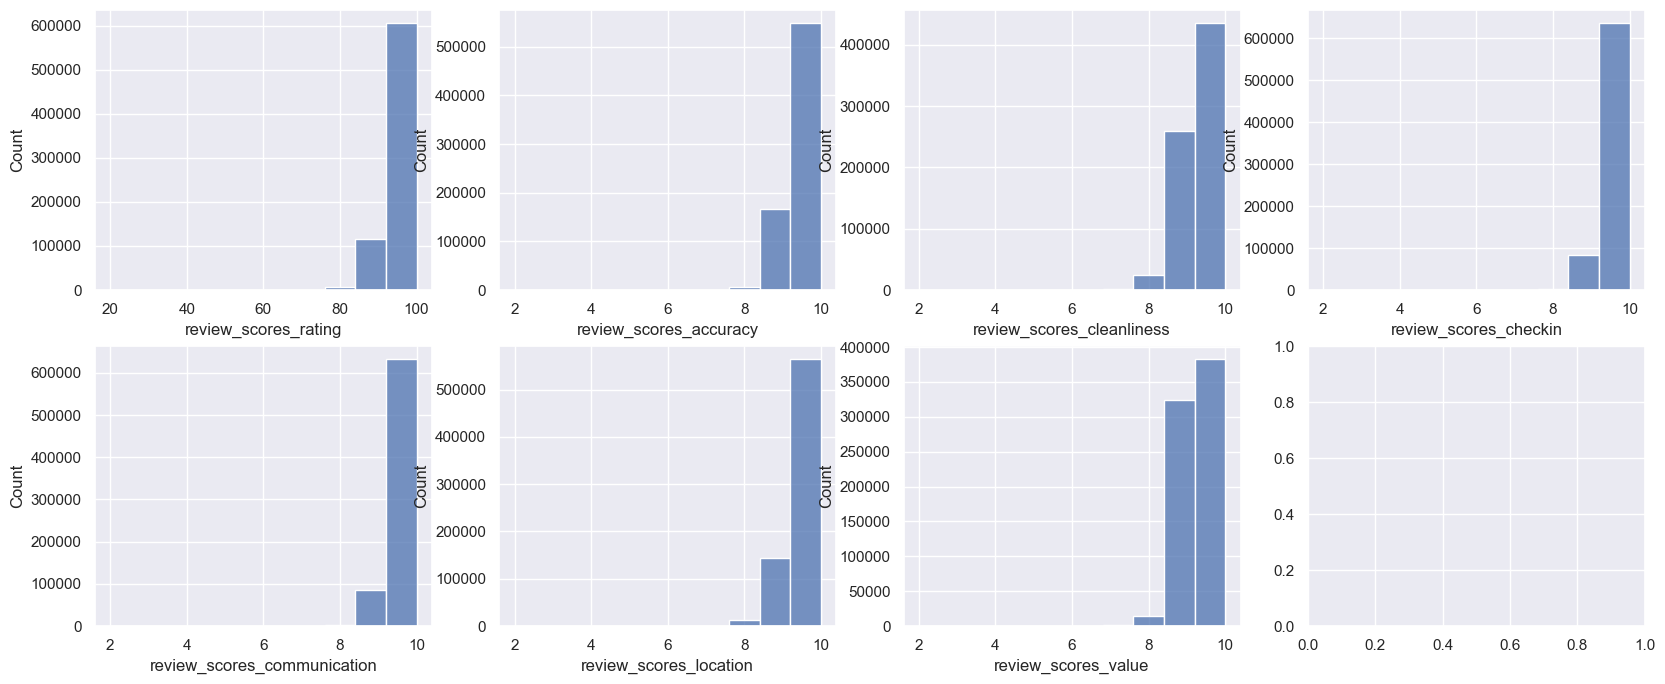

In [381]:
# A visualization would not hurt, right!!
figure, axes = plt.subplots(2, 4,figsize=(20, 8), sharex=False, sharey=False)
for i, rv in enumerate(REVIEWS):  
    sns.histplot(ax=axes[i // 4, i % 4], data=ls, x=rv, bins=10)
plt.show()

In [382]:
# let's measure the skewness of our data.
ls[REVIEWS].skew()

review_scores_rating          -2.263985
review_scores_accuracy        -2.072642
review_scores_cleanliness     -1.353873
review_scores_checkin         -3.541258
review_scores_communication   -3.424692
review_scores_location        -2.126678
review_scores_value           -0.857002
dtype: float64

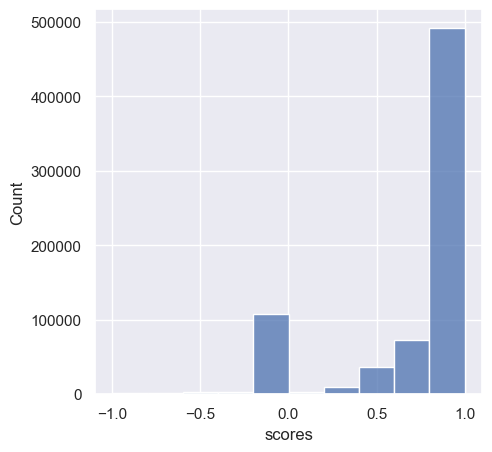

In [383]:
# let's check the scores
sns.histplot(data=ls, x='scores', bins=10)
plt.show()

In [384]:
import random
random.seed(30) # 11 is good

pos_rev_pos = ls[ls['scores'] >= 0.9]['comments'].tolist()
pos_rev_neu = ls[(ls['scores'] > 0) & (ls['scores'] < 0.8)]['comments'].tolist()
pos_rev_neg = ls[ls['scores'] < 0]['comments'].tolist()

s_pos = random.sample(pos_rev_pos, 5)
s_neu = random.sample(pos_rev_neu, 5)
s_neg = random.sample(pos_rev_neg, 5)

for s in s_pos:
    print(s)

print("#" * 100)

for s in s_neu:
    print(s)

print("#" * 100)
for s in s_neg:
    print(s)


We really want to recommend this house. Reasons are below.<br/>1. The owner is very kind.<br/>2. The house is very clean and comfortable.<br/>3. The location is very near from Metro station and easy to access everywhere.<br/>4. There are many interesting books in the house.<br/>5. The ceiling is very high. It means we feel the room bigger.<br/>6. There is nice balcony.<br/>7. The living room facilities are also good. For example, comfortable sofa , good audio system and useful kitchen.<br/>
We just returned home to the United States yesterday after 2 amazing weeks in Italy. We started our trip with 3 days in Rome at Silvioâs apartment and it was prefect. We had 8 adults and there was plenty of room. This is the prefect location. We parked our rental car (which was good considering how everyone drives in Rome). We were able to enjoy all of the sites,  fantastic restaurants, a huge street market all within a few minute walk. I would highly recommend the City Roma tour and the Night Wal

In [385]:
ls['scores'].describe()

count    729536.000000
mean          0.725569
std           0.371340
min          -0.998100
25%           0.658800
50%           0.912100
75%           0.966100
max           0.999800
Name: scores, dtype: float64

a first look at the columns shows that the columns can be divided into 4 main categories:
1. host information
2. geographical information (form city all the way to neighborhood and even the exact coordinates)
3. listing description: more detailed objective information about the listing
4. reviews: reviews scores on differents part of the user's experience 

For this analysis, we will use data with no missing values

As expected the problem is quite unbalanced. Let's drop the unnecessary columns and proceed to better understand how the data varies

In [386]:
RATING_REVIEW = 'review_scores_rating'
# remove all reviews' scores now
ls.drop(columns=[r for r in REVIEWS], inplace=True)

# Data Description: Unique and missing values

In [387]:
# let's procceed by removing duplicates, each listing has its own id. Nevertheless, a listing will be considered dupliacted if it has the same features (except the name and the id)
ls = ls.drop_duplicates(subset=list(ls.columns[2:]))
print(len(ls))
# we don't have too many duplicates

# let's rename the columns

new_cols = {"host_response_time": "res_time", "host_acceptance_rate": "acceptance_rate", 'host_response_rate': 'res_rate',
"host_is_superhost":"superhost", "host_total_listings_count": "ls_count", "host_has_profile_pic": "pf", "host_identity_verified": "identity"}

ls = new_col_names(new_cols, ls)

host_dict = {"t": 1, "f": 0}
ls = map_values(ls, columns=['superhost', 'pf', 'identity', 'instant_bookable'], cols_dicts= [host_dict] * 4)


729531


In [388]:
num_cols, cat_cols = get_col_types(ls)
draw_unique_data_table(ls[cat_cols])

,n_unique
amenities,12843
property_type,68
name,13474
host_location,858
city,10
district,5
superhost,2
neighbourhood,372
pf,2
res_time,4


WE'RE LOOKING AT A HUGE NUMBER OF MISSING VALUES !!

In [389]:
# let's investigate the missing values
draw_missing_data_table(ls)

,Total,Percent
district,649857,0.890787
res_time,118560,0.162515
res_rate,118560,0.162515
acceptance_rate,66275,0.090846
bedrooms,64930,0.089002
host_location,998,0.001368
pf,456,0.000625
identity,456,0.000625
host_since,456,0.000625
superhost,456,0.000625


The following columns are to be removed:
1. The listing id as it does not introduce any valuable insight
2. The district feature as it has more than $85\%$ missing values and can be easily reconstruced from other present geo-spatial data 
3. the name feature as it represents a lengthy description of the listing. (MIGHT BE PROCESSED IN FURTHER ITERATIONS!!!)
4. host's location as it represents a very large number of unique values

In [390]:
ls.drop(columns=['district', 'name', 'host_location', 'host_id'], inplace=True) # '', 'listing_id'

In [391]:
! pip install geopandas 
! pip install osmnx
! pip install h3
! pip install folium


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\bouab\AppData\Local\Programs\Python\Python39\lib\threading.py:914: ResourceWarning: unclosed file <_io.BufferedWriter name=7>
  del self._target, self._args, self._kwargs
C:\Users\bouab\AppData\Local\Programs\Python\Python39\lib\threading.py:914: ResourceWarning: unclosed file <_io.BufferedReader name=9>
  del self._target, self._args, self._kwargs
C:\Users\bouab\AppData\Local\Programs\Python\Python39\lib\threading.py:914: ResourceWarning: unclosed file <_io.BufferedReader name=10>
  del self._target, self._args, self._kwargs
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x230548e31c0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x230548e3400>



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\bouab\DEV\ds_env\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=7>
  return process_handler(cmd, _system_body)
c:\Users\bouab\DEV\ds_env\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=9>
  return process_handler(cmd, _system_body)
c:\Users\bouab\DEV\ds_env\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=10>
  return process_handler(cmd, _system_body)



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x230aa07d160>



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x23193c988e0>


# Building Geo Data

In [393]:
df = ls.dropna()
# let's group the data and see what happens
from datetime import datetime
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.to_period('M')
# df['date'] = pd.to_time(df['date'])

# df['date'] = pd.to_datetime(df['date'])
grouped = pd.pivot_table(df, index=('listing_id', 'date'), values='scores', aggfunc=[np.median])

In [394]:
result = grouped.reset_index()
result.columns = [c[0] if isinstance(c, tuple) else c for c in result.columns]
result = result.rename(columns={"median": "scores"})
df.drop(columns=['scores'], inplace=True)

In [395]:
# as the scores are calculated let's modify the original dataframe
df = pd.merge(df, result, on=('listing_id', 'date'))
df = df.drop_duplicates(subset=['listing_id', 'date'])

In [396]:
df['scores'].describe()

count    247597.000000
mean          0.732695
std           0.344043
min          -0.998100
25%           0.648600
50%           0.901100
75%           0.958800
max           0.999700
Name: scores, dtype: float64

In [397]:
df.columns

Index(['listing_id', 'host_since', 'res_time', 'res_rate', 'acceptance_rate',
       'superhost', 'ls_count', 'pf', 'identity', 'neighbourhood', 'city',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'instant_bookable', 'date', 'comments', 'scores'],
      dtype='object')

In [398]:
print(len(df[df['scores'] == 0]))

28443


[]

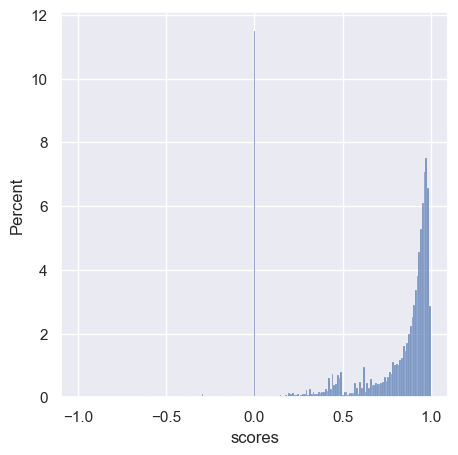

In [399]:
sns.histplot(data=df, x='scores', stat='percent')
plt.plot()

In [400]:
df.columns

Index(['listing_id', 'host_since', 'res_time', 'res_rate', 'acceptance_rate',
       'superhost', 'ls_count', 'pf', 'identity', 'neighbourhood', 'city',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'instant_bookable', 'date', 'comments', 'scores'],
      dtype='object')

In [401]:
# let's set the scoring
# df_t = df.copy()
df['scores'] = 1 + (df['scores'] >= 0.6) + (df['scores'] >= 0.9)      

In [402]:
# # let's try to see how things relate to each other before proceeding even further
# plot_correlation(df)

WELL, WELL, WHAT DO WE HAVE HERE? MOST OF THE NUMERICAL FEATURES IN THEIR ORIGINAL FORMS EXHIBIT LITTLE TO NO CORRELATION TO THE TARGET VARIABLES. MORE INVESTIGATION IN THAT REGARD IS NEEDED.   
TO BETTER UNDERSTAND THE POSSIBLE TRANSFORMATIONS, IT MIGHT BE NECESSARY TO BETTER UNDERSTAND THE DISTRIBUTIONS OF OUR INDEPENDENT VARIABLES

# GEO FUNCTIONS

In [403]:
import geopandas as gpd
import h3
import folium
import osmnx as ox
from shapely import wkt
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiPolygon
from shapely.geometry import mapping
RESOLUTION = 8

import os
from pyproj import Geod


def osm_query(city, tag):
    """extracts all elements that satisfy the tag passed as an argument and returns them in a geopandas

    Args:
        city (_type_): string describing the city in question
        tag (_type_): OSM tags to filter elements

    Returns:

    """
    gdf = ox.geometries_from_place(city, tag).reset_index()
    # print(gdf.shape)
    return gdf


def coordinates_to_h3(lat, lng, res=RESOLUTION):
    return h3.geo_to_h3(lat, lng, res)


# get the h3 address of the hexagone for which the geometry belongs to
def get_h3_geo(g, res=RESOLUTION):
    # longitude
    lng = g.x if isinstance(g, Point) else g.centroid.x     
    # latitude 
    lat = g.y if isinstance(g, Point) else g.centroid.y
    # get h3
    h3_addr = h3.geo_to_h3(lat=lat, lng=lng, resolution=res)
    return h3_addr, lat, lng


# this function returns the area of the passed geometry divided by the scaling constant
def get_area(geo):
    geod = Geod(ellps="WGS84") 
    return abs(geod.geometry_area_perimeter(geo)[0])


def get_h3_point(point):
    # return the h3 address of the hexagone for which the point belongs to
    h3_a, lat, lng = get_h3_geo(point)
    return [h3_a]    

def get_h3_lineString(ls: LineString):
    """this function considers all the points belonging to LineString object and returns a set of all h3 addresses of hexagones
    intersecting this geometry

    Args:
        ls (LineString): A lineString object representing a OpenStreetMap object, generally: highway, road, street...

    Returns:
        set: the set of all h3_address of the hexagones that are spanned by the LineString object
    """
    
    h3_s = set()
    x, y = ls.coords.xy
    for p_x, p_y in zip(x, y):
        # получить адрес h3 шестиугольника, к которому принадлежит эта конкретная точка
        
        h3_addr = h3.geo_to_h3(lat=p_y, lng=p_x, resolution=RESOLUTION)
        
        # добавьте адрес в набор
        h3_s.add(h3_addr)
    return h3_s

def get_h3_Poly(poly: Polygon):
    """this function considers all the points belonging to Polygon object and returns a set of all h3 addresses of hexagones
    intersecting this geometry

    Args:
        poly (Polygone): A Polygone object representing a OpenStreetMap element: large enough not be represented as a point

    Returns:
        set: the set of all h3_address of the hexagones that are spanned by the Polygon object
    """
    h3_s = set()
    x, y = poly.exterior.coords.xy
    for p_x,p_y in zip(x, y):
        # get the h3 address of the hexagone to which this particular point belongs
        h3_addr = h3.geo_to_h3(lat=p_y, lng=p_x, resolution=RESOLUTION)
        # add the address to the set
        h3_s.add(h3_addr)
    return h3_s


def get_h3_MultiPoly(m_poly: MultiPolygon):
    h3_s = set()
    for poly in m_poly.geoms:
        h3_s.update(get_h3_Poly(poly))
    return h3_s

def get_h3_area(g):
    """This function gets the area as well as the set of h3 addresses of hexagones spanned by the given geometry"""
    
    # first get the area
    area = get_area(g)
    addresses = None

    # call the corresponding function depending on the geometry's data type
        
    if isinstance(g, Point):
        addresses = get_h3_point(g)
    elif isinstance(g, LineString):
        addresses = get_h3_lineString(g)
    elif isinstance(g, Polygon):
        addresses = get_h3_Poly(g)
    else:
        addresses = get_h3_MultiPoly(g)
    return area, addresses


import pandas as pd

COLS = ['h3', 'count', 'area']

def get_count_area_tag(city, tag):
    
    # extract the data from osm
    g = osm_query(city, tag).loc[:, 'geometry']
        
    
    # h3_count: maps each h3 address to the number of elements in geopandas "g" that intersect the hexagone h3
    # h3_area: maos each h3 address to the sum of areas of elements in geopandas "g" that intersect the hexagone h3
    h3_count = {}
    h3_area = {}
                
    for geo in g:
        # get the area and the unique address associated with this element: geometry
        area, adds = get_h3_area(geo)

        # for each address
        for ad in adds:
            # if this address was encoutered before increment its count and add the area of the element to its h3_area
            if ad in h3_count:
                h3_count[ad] += 1
                h3_area[ad] += area
            else:
                # if this address if first encountered then set its count to 1 and its area to the element's
                h3_count[ad] = 1
                h3_area[ad] = area

    # convert the dictionaries into dataframe                
    res = pd.DataFrame({"h3": list(h3_area.keys()), "count": list(h3_count.values()), "area": list(h3_area.values())})
    return res

import numpy as np

def get_tags(city, tags, name):
    df_res = pd.DataFrame(data=[], columns=COLS)
    # for each specific tag
    for t in tags:
        # create the count and area dataframe associated with the specific dataframe
        df_tag = get_count_area_tag(city, t)
        # add it to previous dataframes    
        df_res = pd.concat([df_res, df_tag])
    
    # as several h3 address can repeat accross different tags: we group by h3 addresses
    # and sum up all their associated areas and counts
    
    df_res_area = pd.pivot_table(df_res, index='h3', values=['area'], aggfunc=[np.sum])
    df_res_count = pd.pivot_table(df_res, index='h3', values=['count'], aggfunc=[np.sum])
    final_df = pd.merge(df_res_count, df_res_area, right_index=True, left_index=True)
    final_df.columns = [f"{name}_count", f"{name}_area"]
    # final_df.to_excel(os.path.join("osm_features", f"{name}.xlsx"))
    return final_df


# Analysing GEO DATA

In [405]:
def add_h3(row):
    row['h3'] =  coordinates_to_h3(row['latitude'], row['longitude'])
    return row

In [406]:
# create the h3 index of each location in the dataset
df = df.apply(add_h3, axis=1)

In [408]:
# the list of cities in the dataset
CITIES = ['Istanbul',
 'Sydney',
 'Mexico City',
 'Hong Kong',
 'Bangkok',
 'New York',
 'Rome',
 'Rio de Janeiro',
 'Paris']

In [409]:
# let's create a function to add the necessary tags to our dataset
def add_tags(df: pd.DataFrame, tags: list[dict], name: str):
    # iterate through the cities
    final_df = None
    for c in CITIES:
        # extract the slice corresponding to the city
        city_df = df[df['city'] == c]
        # get the data for the tags in consideration
        tag_df = get_tags(c, tags, name).reset_index(names='h3') 
        
        assert 'h3' in list(city_df.columns), 'h3 not in df'
        assert 'h3' in list(tag_df.columns), 'h3 not in tags' 
        
        # combine the data all together
        inter_res = pd.merge(city_df, tag_df, on='h3', how='left')
        
        assert len(inter_res) == len(city_df)

        # the nan values should be filled with zeros
        inter_res[[f'{name}_count' ,f'{name}_area']].fillna(value=0, inplace=True)

        if final_df is None :
            final_df = inter_res
        else:
            final_df = pd.concat([final_df, inter_res], axis=0, ignore_index=True)
    
    return final_df

In [410]:
enter_tags = [{"amenity":"gambling"}, {"amenity":"nightclub"}, {"amenity": "cinema"}]

tags_financial = [{"amenity": "atm"}, {"amenity": "bank"}, {"amenity": "bureau_de_change"}]

sus_tags = [{"amenity":"bar"}, {"amenity":"cafe"}, {"amenity":"fast_food"}, {"amenity":"food_court"}, 
            {"amenity":"ice_cream"}, {"amenity":"pub"}, {"amenity":"restaurant"}]

shop_tags = [{"shop": "alcohol"}, {"shop": "greengrocer"}, {"shop": "convenience"}]

transport_tags = [{"public_transport": "station"}]

tourism_tags = [{"tourism": "attraction"}, {"tourism": "museum"}, {"historic": "monument"}]

police_tags = [{"amenity": "police"}]

In [411]:
tags = [enter_tags, tags_financial, sus_tags, shop_tags, transport_tags, tourism_tags, police_tags]
names = ['entertainment', 'financial', 'sustenance', 'shopping', 'transport', 'tourism', 'safety']

In [412]:
# let's test it with the first set of tags
df_t = df.copy()
for t, n in zip(tags, names):
    t_res = add_tags(df_t, t, n)
    len(t_res)
    t_res = t_res.loc[:, [f'{n}_count', f'{n}_area', 'listing_id', 'date']]
    df_t = pd.merge(df_t, t_res, on=['listing_id', 'date'])


In [413]:
df.drop(columns=['listing_id'], inplace=True)

In [ ]:
corr = plot_correlation(df_t, figsize=(12, 12))

In [415]:
df_t.to_csv('final_data.csv', index=False)

In [417]:
# let's apply the log transformation on our new data
new_cols = [c for c in df.columns if (c.endswith('_count') or c.endswith('_area')) and c !='ls_count']

print(new_cols)

for c in new_cols:
    df[c] = np.log(100 + df[c])

num_cols, cat_cols = get_col_types(df)

for c in num_cols:
    if c not in ['host_id', 'listing_id'] + new_cols:
        df[c] = np.log(3 + df[c]) # so the values are larger than 1


['entertainment_count', 'entertainment_area', 'financial_count', 'financial_area', 'sustenance_count', 'sustenance_area', 'shopping_count', 'shopping_area', 'transport_count', 'transport_area', 'tourism_count', 'tourism_area', 'safety_count', 'safety_area']


c:\Users\bouab\DEV\ds_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Data Distributions

### NUMERICAL FEATURES

['shopping_count', 'acceptance_rate', 'listing_id', 'price', 'tourism_count', 'latitude', 'minimum_nights', 'sustenance_area', 'maximum_nights', 'safety_area', 'financial_area', 'sustenance_count', 'ls_count', 'tourism_area', 'res_rate', 'longitude', 'shopping_area', 'financial_count', 'transport_area', 'entertainment_area']
20


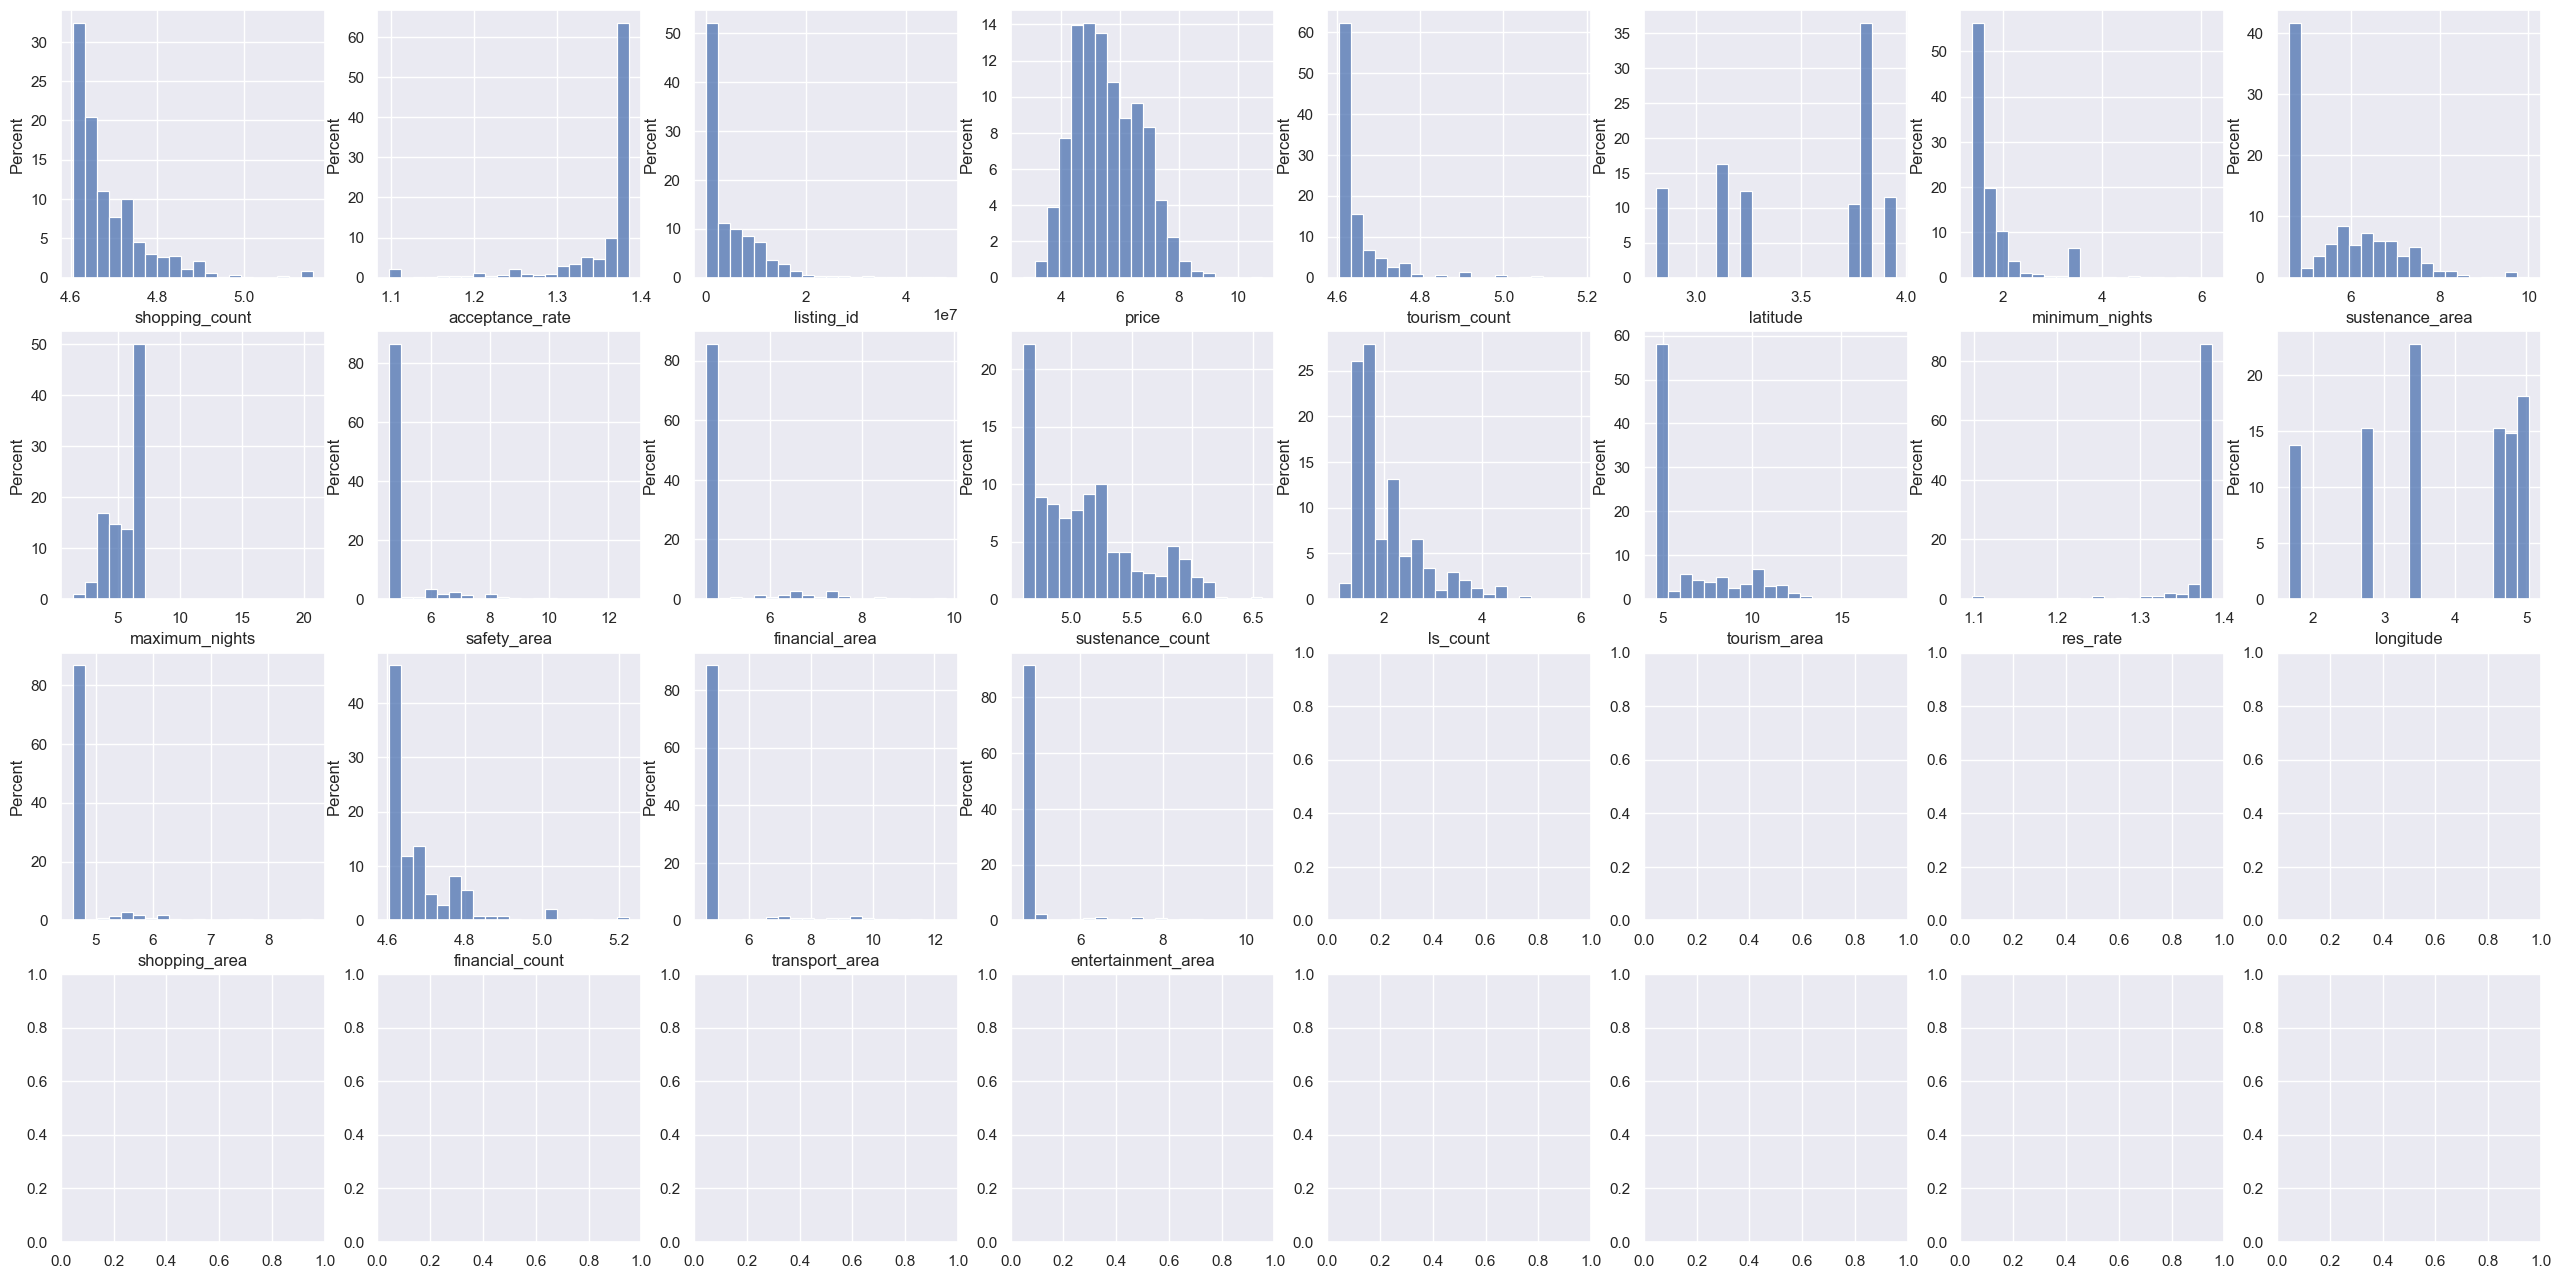

In [418]:
# let's display the distribution of the numerical variables
num_cols, cat_cols = get_col_types(df)
print(num_cols)
print(len(num_cols)
      )
# we have 11 numerical features

figure, axes = plt.subplots(4, 8,figsize=(32, 16), sharex=False, sharey=False)
for i, rv in enumerate([n_c for n_c in num_cols if n_c != 'host_id']):  
    # log_scale = 10 if np.max(df[rv]) >= 10 ** 4 else None
    sns.histplot(ax=axes[i // len(axes[0]), i % len(axes[0])], data=df, x=rv, bins=20, stat='percent')
plt.show()

* HAVE YOU HEARD OF THE SAYING "LIKE INDEPENDENT VARIABLE, LIKE DEPENDENT VARIABLE" ? WE CAN SEE THAT THE VALUES ARE JUST AS SKEWED AS THE TARGET VARIABLE.


In [419]:
df[num_cols].skew()

shopping_count        2.004680
acceptance_rate      -2.771315
listing_id            2.448418
price                 0.375404
tourism_count         3.105934
latitude             -0.525697
minimum_nights        2.441077
sustenance_area       0.803845
maximum_nights       -0.506312
safety_area           3.333368
financial_area        2.797597
sustenance_count      0.746175
ls_count              1.459930
tourism_area          1.062711
res_rate             -5.278314
longitude            -0.517323
shopping_area         3.901959
financial_count       2.318320
transport_area        3.114782
entertainment_area    4.223641
dtype: float64

What can we do about the skewness of our data, WELL we can address it with a couple of transformations:
* log transformation
* box-cox transformation
* inverse transformations possibly

In [420]:
from scipy.stats import boxcox

def transformations(df: pd.DataFrame, cols:list=None):
    df = df.copy()
    # first extract the numerical features i
    if cols is None:
        cols, cat_cols = get_col_types(df)

    for c_n in cols:
        if (df[c_n] >= 0).all():
            df[f'{c_n}_log'] = np.log(1 + df[c_n])
    
    for c_n in cols: 
        # make sure the data is strictly positive
        if (df[c_n] > 0).all():
            # calculate the new column and the lamda coefficient
            new_col, alpha = boxcox(df[c_n])
            df[f'{c_n}_boxcox_{round(alpha, 3)}'] = new_col

    # drop any generated columns that have nan values
    generated_cols = [c for c in df.columns if 'log' in c or 'boxcox' in c]
    # as pandas does not offer the possibility of removing a subset of columns 
    nan_vals = df[generated_cols].isna().sum() 
    # extract those that have at least one nan value
    cols_to_drop = nan_vals[nan_vals > 0].index
    # drop them
    return df.drop(columns=cols_to_drop)

# df_t = transformations(df, cols=[c for c in num_cols if c not in  ['host_id','listing_id'] + new_cols] )


In [421]:
# let's do some more visualization to see if things got any better
# figure, axes = plt.subplots(2, 6, figsize=(25, 16), sharex=False, sharey=False)

# for i, col in enumerate(t_cols):  
#     log_scale = 10 if np.max(df_t[col]) >= 10 ** 4 else None
#     sns.histplot(ax=axes[i // 2, i % 6], data=df_t, x=col, bins=20, log_scale=log_scale, stat='percent')
# plt.show()

IT SEEMS THAT THE MOST COMMON DATA TRANSFORMATIONS TECHNIQUES DID NOT INTRODUCE ANY NOTICEABLE IMPROVEMENT IN THE CORRELATION WITH THE TARGET VARIABLE.  
NEVERTHELESS, WE SHOULD NOT LOSE HOPE... A CHANGE OF PERSPECTIVE IS NEEDED.   
THE SKEWNESS OF THE DATA CAN BE PARTIALLY EXPLAINED BY THE PRESENCE OF OUTLIERS, HOW WOULD OUR DATA LOOK LIKE WITHOUT SUCH DATA POINTS?

In [422]:
# # let's see the distribution of the values after clipping
# df_clipped = df.copy()
# for n_c in num_cols:
#     if n_c not in new_cols: 
#         lower, upper = detect_outliers(df, column=n_c)
#         df_clipped[n_c] = df_clipped[n_c].clip(lower=lower, upper=upper)

# # repeating the same code as above, let's see if there is any difference
# figure, axes = plt.subplots(4, 8,figsize=(32, 16), sharex=False, sharey=False)
# for i, rv in enumerate([n_c for n_c in num_cols if n_c != 'host_id']):  
#     log_scale = 10 if np.max(df[rv]) >= 10 ** 4 else None
#     sns.histplot(ax=axes[i // len(axes[0]), i % len(axes[0])], data=df_clipped, x=rv, bins=20, log_scale=log_scale, stat='percent')
# plt.show()

We can see that clipping the outliers (whether outliers with low or high values) generate a more descriptive and detailed description of the dataset. Throwing the outliers is not a sound decision as this type of rows do encode quite a lot of information. Let's investigate what outliers have to offer.


In [423]:
# corr = plot_correlation(df_clipped)

WE can see that clipping the data SLIGHTLY increases in the values of the correlations with the target variable. This slight improvement is not enough of a reason to discard the outliers.

In [424]:
# df = df_clipped.copy()

### CATEGORICAL FEATURES

9


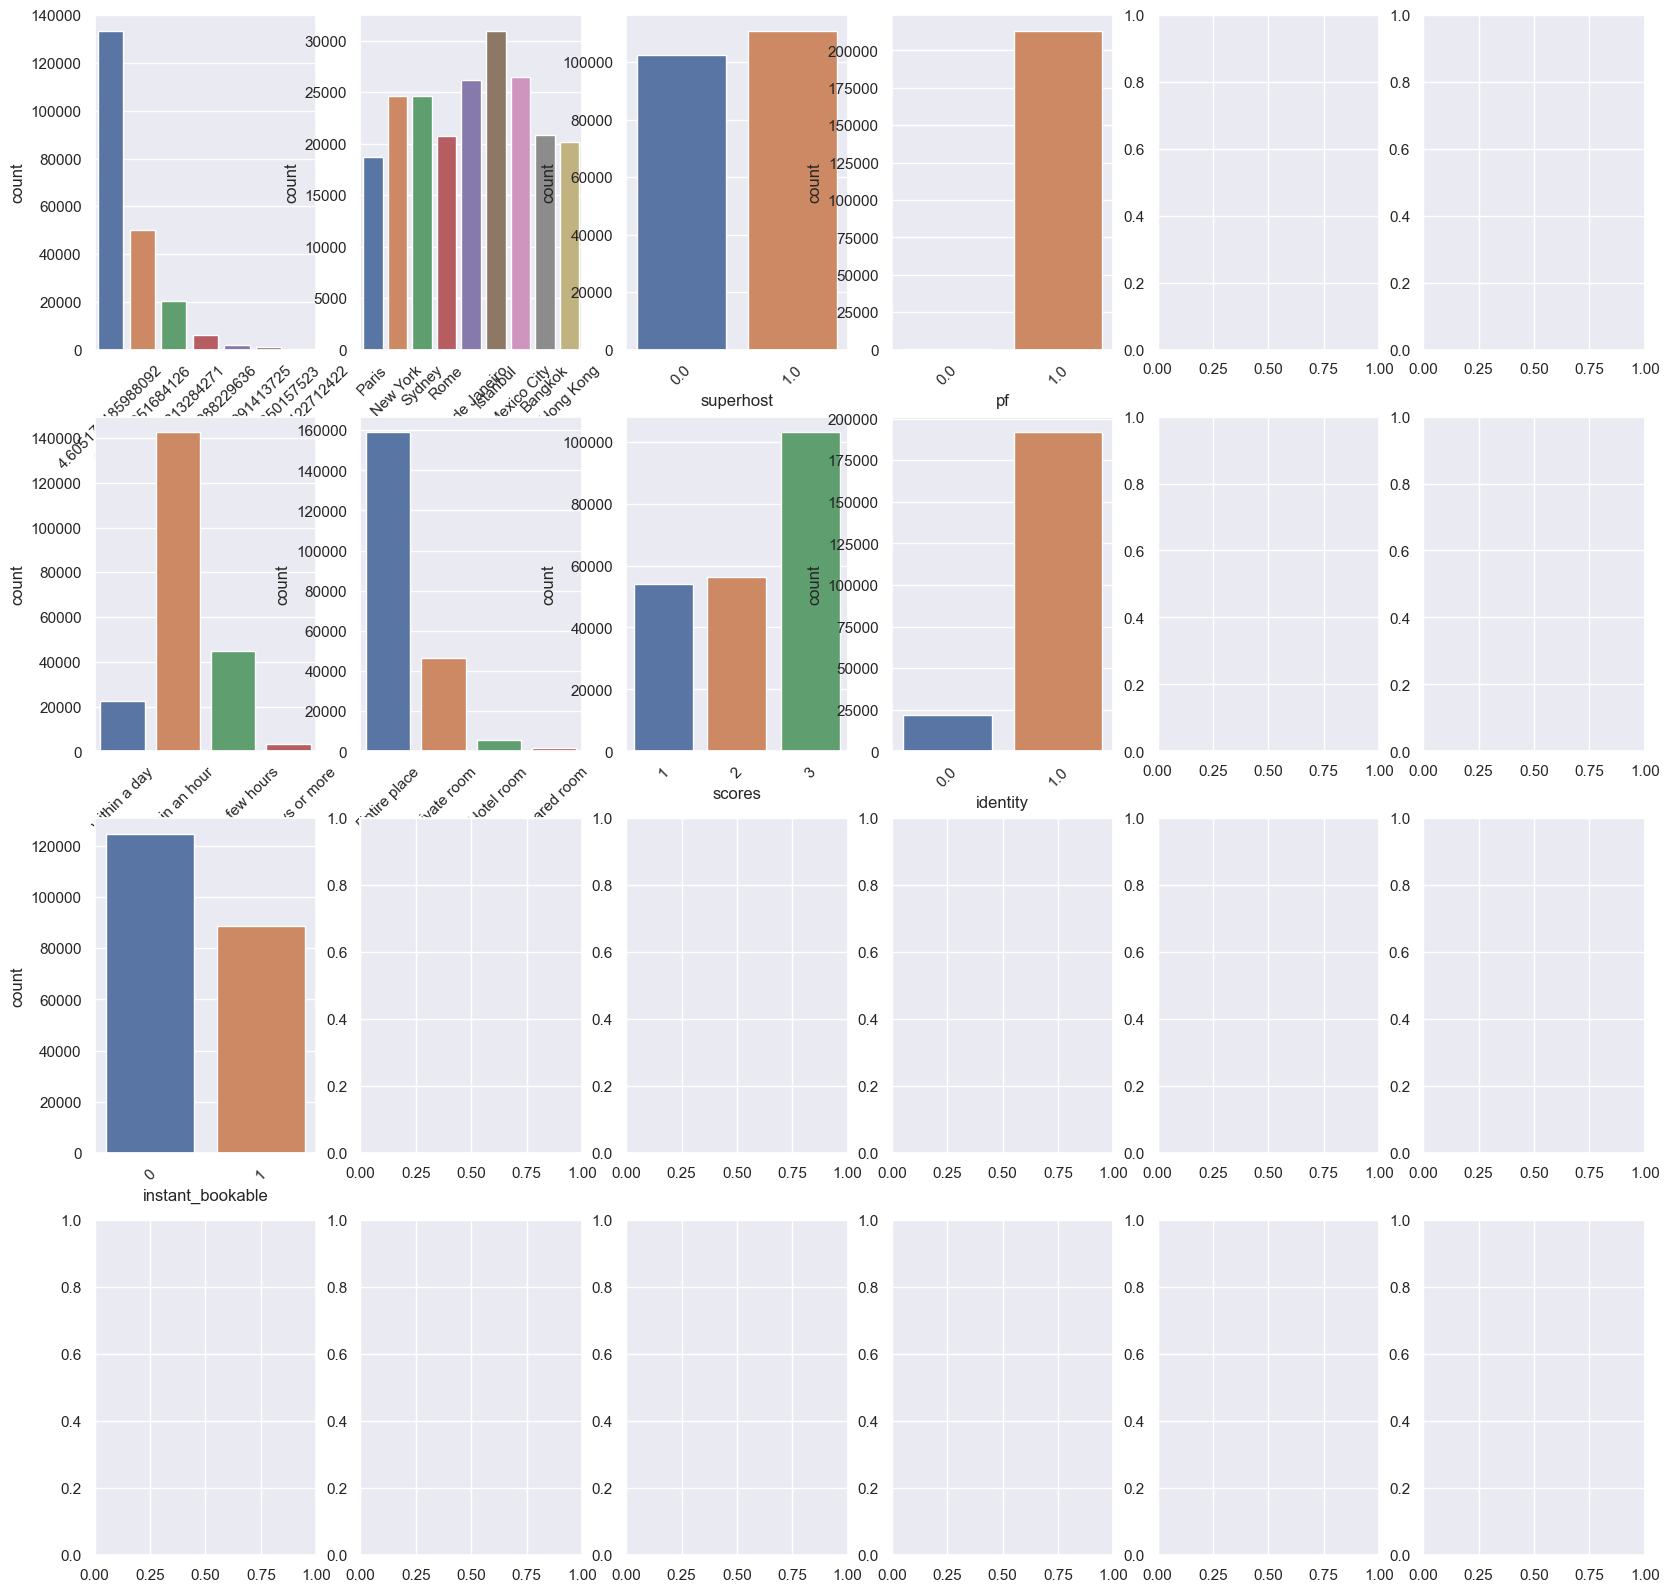

In [425]:
# let's consider the distributions for categorical columns as 
num_cols, cat_cols = get_col_types(df, nunique_as_discrete=10)

print(len([c for c in cat_cols if len(df[c].value_counts()) <= 10]))

figure, axes = plt.subplots(4, 6,figsize=(20, 20), sharex=False, sharey=False)
for i, f in enumerate([c for c in cat_cols if len(df[c].value_counts()) <= 10]):  
    chart = sns.countplot(ax=axes[i // 4, i % 4], data=df, x=f)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

UNLIKE THE NUMERICAL FEATURES, THE CATEGORICAL FEATURES VARY SIGNIFICANTLY MORE IN TERMS OF DISTRIBUTIONS, AS WE CAN FIND: 
1. HEAVILY UMBALANCED FEATURES: host_has_profile_pic, host_identity_verified
2. SLIGHTLY UNBALANCED: host_is_superhost, res_time
3. QUITE BALANCED: instant_bookable, city

OUT OF THE 14 CATEGORICAL VARIABLES IN OUR DATAFRAME, 11 OF THEM HAVE AT MOST 10 UNIQUE VALUES. SUCH OBSERVATION SUGGESTS THE PROBLEM OF LARGE NUMBER OF UNIQUE VALUES. LET'S INVESTIGATE THIS ISSUE A BIT MORE.

# Bridging the gap between description and preparation: reducing unique values

## categorical columns

In [426]:
num_cols, cat_cols = get_col_types(df)
draw_unique_data_table(df)

,n_unique
listing_id,6470
host_since,1927
res_time,4
res_rate,52
acceptance_rate,90
superhost,2
ls_count,81
pf,2
identity,2
neighbourhood,281


THE FEATURES NEIGHBORHOOD, HOST_SINCE, PROPERTY_TYPE AND AMENITIES CAN PROVIDE INFORMATIVE INSIGHT (FROM A DOMAIN KNOWLEDGE PERSPECTIVE). NEVERTHELESS, THE LARGE NUMBER OF UNIQUE VALUES MAY STAND IN THE WAY TO TAKING FULL ADVANTAGE OF SUCH COLUMNS.

### host_since feature

In [427]:
df_c = df.copy()

NEVERTHELESS THE NUMBER HOST EXPERIENCE'S DOES NOT SEEM TO INTERACT SIGNIFICANTLY WITH THE TARGET VARIABLE.

### The type of the listing
Let's consider the different variables that represent the types of the listing

In [434]:
print(df['room_type'].value_counts())
print(df['property_type'].value_counts())

Entire place    158858
Private room     46743
Hotel room        5869
Shared room       1768
Name: room_type, dtype: int64
Entire apartment                      117787
Private room in apartment              22943
Entire loft                            10217
Entire condominium                      9914
Entire house                            8893
Private room in house                   8794
Room in boutique hotel                  3947
Entire serviced apartment               2910
Private room in bed and breakfast       2609
Entire guesthouse                       2508
Entire guest suite                      2232
Room in hotel                           2066
Private room in hostel                  2046
Private room in townhouse               2017
Entire townhouse                        1479
Private room in guesthouse              1169
Private room in loft                    1130
Room in serviced apartment              1062
Private room in condominium             1029
Room in hostel         

We can see that the property type feature introduces additional information as well as complexity. $106$ unique values is quite a large number. Let's try to understand how the target variable varies with respect to the ***room_type*** feature.

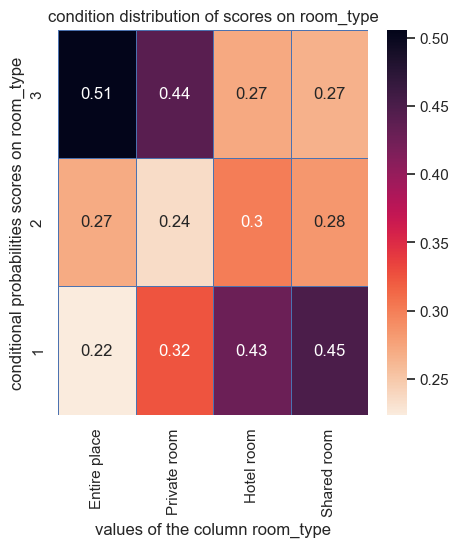

In [435]:
visualize_cond_prob(data=df, target='scores', hue='room_type')

The type of the property might not be a determining factor in the review, as the current values are quite close to the generat distribution of the binary classes of the target variable. Nevertheless, the exact number of bedrooms or the number of guests to accommodate is more likely to affect user's review.  

TO ELABORATE IN MORE DETAILS, it might be more important for an entire place to accomodate more guests, while for private / shared rooms to accomodate the least number of guests

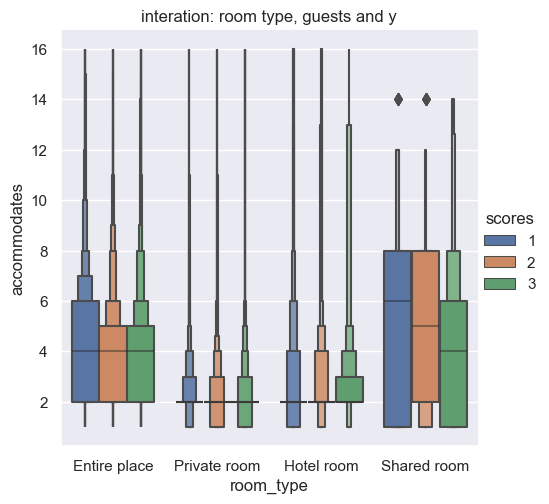

In [436]:
# let's understand the interaction between the target variable, room_type and the number of guests
sns.catplot(data=df, x='room_type', y='accommodates', hue='scores', kind='boxen')
plt.title('interation: room type, guests and y')
plt.show()

THE PLOTS ABOVE SHOW THAT THE TYPE OF LISTINGS MIGHT BE OF NO OR LITTLE IMPORTANCE WHEN PREDICTING THE TARGET VARIABLE.

In [437]:
# we can see that the largest variation is in the 'Entire place' column. We can infer the (average) area of the property from the property type feature

from collections import Counter
import re
# a list to save the building blocks
properties = Counter()

for value in df['property_type']:
    # first convert to lower case, remove any training and heading spaces and split the text
    new_val = value.lower().strip()
    # split the
    properties.update(re.split(r'\s+', new_val))

print(properties)

HOUSE_TYPES = set([t for t, v in properties.items() if v >= 2000 and t not in ['entire', 'private', 'in']])
print(HOUSE_TYPES)

Counter({'entire': 157981, 'apartment': 146308, 'room': 54869, 'in': 54723, 'private': 43907, 'house': 18163, 'loft': 11347, 'condominium': 10948, 'hotel': 6027, 'serviced': 4736, 'boutique': 3961, 'guesthouse': 3734, 'hostel': 3548, 'townhouse': 3496, 'bed': 3109, 'and': 3109, 'breakfast': 3109, 'guest': 3095, 'suite': 3095, 'shared': 1768, 'aparthotel': 811, 'cottage': 746, 'villa': 530, 'bungalow': 384, 'cabin': 377, 'tiny': 235, 'chalet': 91, 'train': 67, 'place': 61, 'treehouse': 50, 'boat': 48, 'farm': 47, 'stay': 47, 'floor': 46, 'nature': 36, 'lodge': 36, 'minsu': 23})
{'condominium', 'and', 'boutique', 'hostel', 'serviced', 'room', 'guesthouse', 'loft', 'bed', 'suite', 'breakfast', 'townhouse', 'guest', 'apartment', 'hotel', 'house'}


In [438]:
def set_listing_type(row):
    properties = row['property_type'].lower().strip()
    properties = re.split(r'\s', properties) 
    for p in properties:
        if p in HOUSE_TYPES:
            row['listing_type'] = p
            return row
    # set the rest to other
    row['listing_type'] = 'Other'
    return row

df = df.apply(set_listing_type, axis=1)

In [439]:
assert len(df) >= 200000

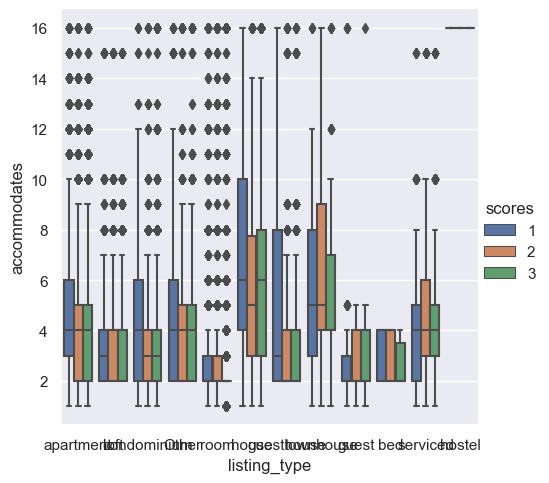

In [440]:
# let's see how the listing_type 

sns.set(rc={"figure.figsize":(5, 5)})
g = sns.catplot(data=df, y='accommodates', x='listing_type', hue='scores', kind='box')
plt.show()

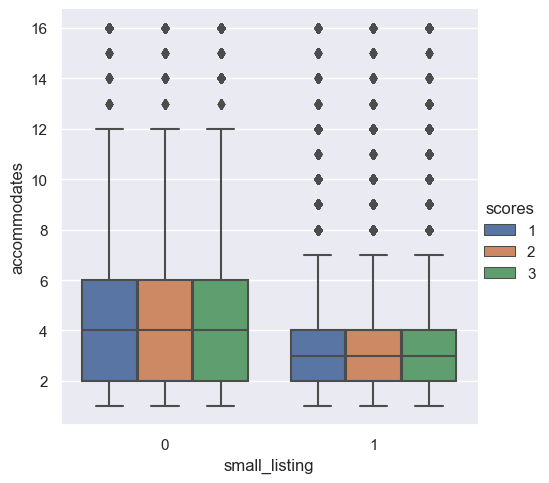

In [441]:
# the number of guests is seemingly significant only for small listings: room, apartment, loft...
# let's verify this hypothesis
df['small_listing'] = df['listing_type'].isin(['apartment', 'loft', 'room']).astype(int)
sns.catplot(data=df, y='accommodates', x='small_listing', hue='scores', kind='box')


THE ANALYSIS ABOVE INDICATES, that despite considering several transformations and categorizations of the listing's type, no relevant interaction was found. The type of listing will be dropped from the data.

### Bedrooms and guests

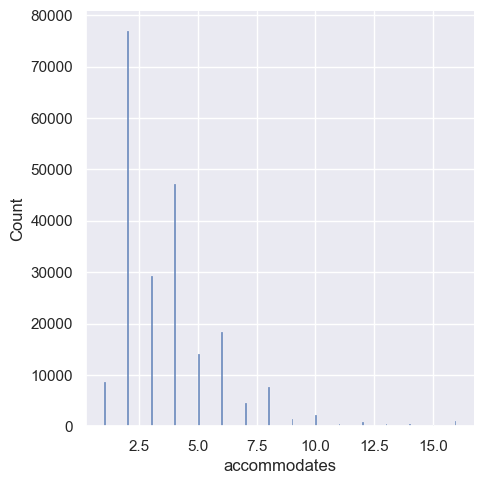

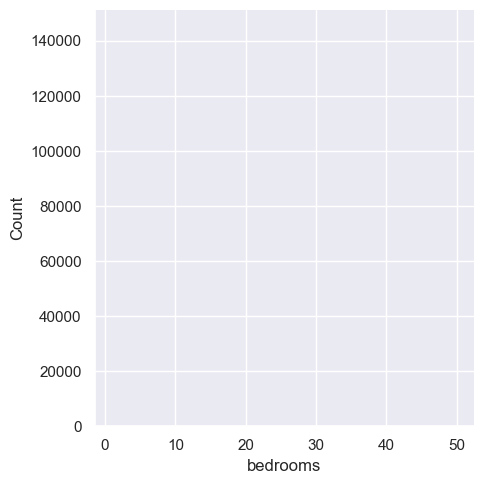

In [442]:
# let's see if the number of guests can be linked to the price.
# first let's display the distribution of the number of guests
sns.displot(data=df, x='accommodates')
sns.displot(data=df, x='bedrooms')
plt.show()

In [443]:
df['bedrooms'] = df['bedrooms'].apply(np.ceil)
print(df[['bedrooms', 'scores', 'accommodates']].corr())

              bedrooms    scores  accommodates
bedrooms      1.000000  0.020759      0.763265
scores        0.020759  1.000000     -0.013837
accommodates  0.763265 -0.013837      1.000000


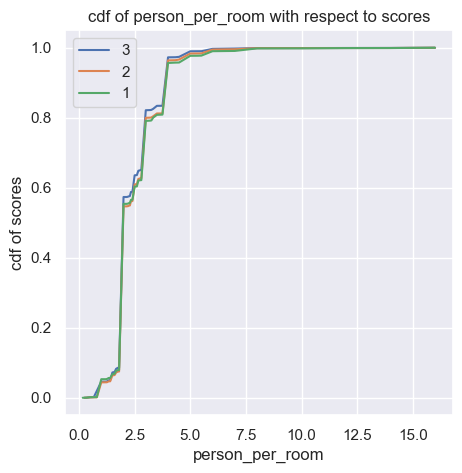

In [444]:
# we can see that the number of guests and bedrooms are quite correlated. The number of bedrooms per person might represent an even more informative feature
df['person_per_room'] = df['accommodates'] / df['bedrooms']
visualize_num_cat(df, num_feat='person_per_room', cat_feat='scores', num_cat='cdf')

THE PLOTS + THE CORRELATION SIMPLY PROVES THAT THE NUMBER OF GUESTS CAN BE PREDICTED FROM THE NUMBER OF BEDROOMS AND VICE VERSA. NEVERTHELESS, THE EXACT NUMBER OF GUESTS SEEMS SLIGHTLY MORE INFORMATIVE. THUS IT IS THE ONE TO BE KEPT.

In [445]:
df.columns

Index(['listing_id', 'host_since', 'res_time', 'res_rate', 'acceptance_rate',
       'superhost', 'ls_count', 'pf', 'identity', 'neighbourhood', 'city',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'instant_bookable', 'date', 'comments', 'scores', 'h3',
       'entertainment_count', 'entertainment_area', 'financial_count',
       'financial_area', 'sustenance_count', 'sustenance_area',
       'shopping_count', 'shopping_area', 'transport_count', 'transport_area',
       'tourism_count', 'tourism_area', 'safety_count', 'safety_area', 'exp',
       'listing_type', 'small_listing', 'person_per_room'],
      dtype='object')

In [446]:
df.drop(columns=['bedrooms', 'property_type', 'room_type', 'bedrooms', 'person_per_room', 'listing_type', 'small_listing'], inplace=True)
assert len(df) >= 200000

### Ameneties

In [447]:
df_a = df.copy()

In [448]:
# let's have a test of the amenities
print(df['amenities'].iloc[0])
print(df['amenities'].iloc[1])
print(df['amenities'].iloc[2])

["Essentials", "Hangers", "Smoke alarm", "Wifi", "Long term stays allowed", "Dedicated workspace", "Building staff", "TV", "Iron", "Refrigerator", "Free street parking", "Heating", "Kitchen", "Hair dryer", "Coffee maker", "Washer", "Microwave", "Cooking basics", "Fire extinguisher", "Cable TV", "Paid parking off premises", "Shampoo", "Carbon monoxide alarm"]
["Essentials", "Hangers", "Smoke alarm", "Wifi", "Long term stays allowed", "Dedicated workspace", "Building staff", "TV", "Iron", "Refrigerator", "Free street parking", "Heating", "Kitchen", "Hair dryer", "Coffee maker", "Washer", "Microwave", "Cooking basics", "Fire extinguisher", "Cable TV", "Paid parking off premises", "Shampoo", "Carbon monoxide alarm"]
["Essentials", "Hangers", "Smoke alarm", "Wifi", "Long term stays allowed", "Dedicated workspace", "Building staff", "TV", "Iron", "Refrigerator", "Free street parking", "Heating", "Kitchen", "Hair dryer", "Coffee maker", "Washer", "Microwave", "Cooking basics", "Fire extinguis

In [449]:
import re
from collections import Counter
# let's try to tackle the problem of amenities.
ameneties_counter = Counter()

for a in df['amenities']:
    a = a[1:-1] # the field is a string and not a list
    # let's remove any non-alpha numerical characters
    a = re.sub(r'[^\w\s,-]+', '', a)
    ameneties_counter.update([a.strip() for a in re.split(r',', a.lower())])
    
print(len(ameneties_counter))
print(ameneties_counter)

397
Counter({'wifi': 208506, 'essentials': 198198, 'long term stays allowed': 196657, 'hair dryer': 187904, 'hangers': 183882, 'hot water': 182062, 'tv': 180659, 'kitchen': 178758, 'iron': 176727, 'dedicated workspace': 162175, 'refrigerator': 159816, 'dishes and silverware': 158790, 'shampoo': 155909, 'air conditioning': 146200, 'cooking basics': 143874, 'washer': 143212, 'smoke alarm': 139983, 'heating': 136481, 'microwave': 130082, 'stove': 124088, 'coffee maker': 123905, 'bed linens': 115459, 'fire extinguisher': 111120, 'cable tv': 102399, 'carbon monoxide alarm': 99235, 'luggage dropoff allowed': 98252, 'oven': 94519, 'elevator': 88878, 'extra pillows and blankets': 88302, 'dryer': 82831, 'free street parking': 80334, 'first aid kit': 79333, 'host greets you': 68936, 'patio or balcony': 67620, 'paid parking off premises': 64998, 'dishwasher': 46436, 'free parking on premises': 43181, 'private entrance': 37255, 'garden or backyard': 36399, 'building staff': 34587, 'lockbox': 30471

In [450]:
# let's remove any amenity that does not appear in at least 5% of the listings.
FINAL_AMENITIES = [a for a, freq in ameneties_counter.items() if freq >= 0.05 * len(df)]
print(FINAL_AMENITIES)

['essentials', 'hangers', 'smoke alarm', 'wifi', 'long term stays allowed', 'dedicated workspace', 'building staff', 'tv', 'iron', 'refrigerator', 'free street parking', 'heating', 'kitchen', 'hair dryer', 'coffee maker', 'washer', 'microwave', 'cooking basics', 'fire extinguisher', 'cable tv', 'paid parking off premises', 'shampoo', 'carbon monoxide alarm', 'hot water', 'host greets you', 'oven', 'dishes and silverware', 'ethernet connection', 'extra pillows and blankets', 'bed linens', 'first aid kit', 'pack u2019n playtravel crib', 'patio or balcony', 'stove', 'lockbox', 'dishwasher', 'luggage dropoff allowed', 'crib', 'high chair', 'dryer', 'room-darkening shades', 'keypad', 'elevator', 'childrenu2019s books and toys', 'indoor fireplace', 'window guards', 'bathtub', 'babysitter recommendations', 'garden or backyard', 'single level home', 'free parking on premises', 'breakfast', 'freezer', 'laundromat nearby', 'shower gel', 'cleaning before checkout', 'pocket wifi', 'body soap', 'ai

The next step is to assign a numerical score for the amenity: V1 - V2 where
1. V1 is the average frequency of the amenity in listings with positive reviews
2. V2 is the averge frequency of the amenity in the listings with negative reviews

In [451]:
NEGATVE_AMENTIY_COUNTER = Counter()
POSITIVE_AMENTIY_COUNTER = Counter()

def set_amentities(row):
    # first let's clean the amenities
    a = row['amenities']
    a = a[1:-1]
    a = re.sub(r'[^\w\s,-]', '', a)
    # only keep the needed amenities
    final_a = [a.strip() for a in re.split(r',', a.lower()) if a.strip() in FINAL_AMENITIES]
    
    # update the frequency of each item in the corresponding counter
    if row['scores'] == 3:
        NEGATVE_AMENTIY_COUNTER.update(final_a)
    else:
        POSITIVE_AMENTIY_COUNTER.update(final_a)
    
    # set the result to the row value
    row['final_amenities'] = final_a

    return row

# apply this function on each row in the dataframe

In [452]:
df = df.apply(set_amentities, axis=1)

In [453]:
assert len(df) >= 200000

The next step is to estimate the conditional probability:
$$ P(positive | amenity~a) = \frac{P(positive~\&~a)}{P(a)}  = \frac{\frac{count(positive~\&~a)}{count(listings)}}{\frac{count(a)}{count(listings)}} = \frac{count(positive~\&~a)}{count(a)}$$

In [454]:
# after running the cells above, we can estimate the conditional probability: P(positive | amenity a present) for each of the most frequent amenitie
AMENITIES_COND_PROB = Counter()

for a in FINAL_AMENITIES:
    # first extract positive count
    pos_count = POSITIVE_AMENTIY_COUNTER[a]
    # extract the negative count as well to cover the denominator
    neg_count = NEGATVE_AMENTIY_COUNTER[a]
    AMENITIES_COND_PROB.update({a:(pos_count / (pos_count + neg_count))})

In [455]:
# let's how our amenities are doing
print(AMENITIES_COND_PROB)

Counter({'building staff': 0.6309596091016856, 'lock on bedroom door': 0.6059505213063537, 'keypad': 0.5906821963394343, 'elevator': 0.5878057562051351, 'gym': 0.5831690883256176, 'pool': 0.5508084603368937, 'cleaning before checkout': 0.5397510795021591, 'fire extinguisher': 0.5396058315334773, 'air conditioning': 0.5393844049247606, 'paid parking on premises': 0.5341267787839586, 'free parking on premises': 0.5282184294018203, 'long term stays allowed': 0.5273089694239208, 'luggage dropoff allowed': 0.5266661238448073, 'tv': 0.5217730641706197, 'hangers': 0.5207089329026223, 'shampoo': 0.520553656299508, 'essentials': 0.5204290658836114, 'private entrance': 0.5201449469869817, 'cable tv': 0.5200246096153283, 'wifi': 0.5160474998321392, 'hot water': 0.5154178246970812, 'first aid kit': 0.5123214803423544, 'window guards': 0.5107536764705882, 'dedicated workspace': 0.5099922922768614, 'microwave': 0.5096246982672468, 'hair dryer': 0.5092068290190735, 'ethernet connection': 0.5053325662

In [456]:
# now we have a way to numerically represent the amenities column in our table
def convert_amenities(row):
    # first iterate through the final amenities
    # extract the amenities
    score = sum([np.log(1 + AMENITIES_COND_PROB[a]) for a in row['final_amenities']])
    # score = np.exp(np.mean([AMENITIES_COND_PROB[a]  for a in row['final_amenities']]) if row['final_amenities'] else 0) 
    row['amenities_score'] = score
    return row 
    # let's consider


In [457]:
df= df.apply(convert_amenities, axis=1)

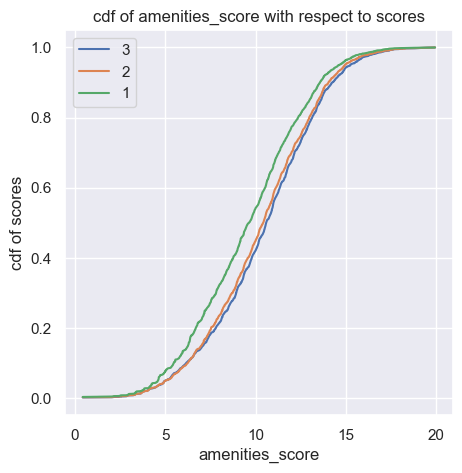

In [458]:
# let's visualize the amenities_score and see if our feature engineering led to any useful insights
visualize_num_cat(data=df, num_feat='amenities_score', cat_feat='scores', num_cat='cdf')

In [459]:
# Certain values of the amenities include the term 'host'. Even though no such amenity had a frequency larger than 5%, it is still worth investigating this point further
def host_engagement(row):
    row['host_as_amenity'] = int('host' in row['amenities'].lower().strip())
    return row

df = df.apply(host_engagement, axis=1)

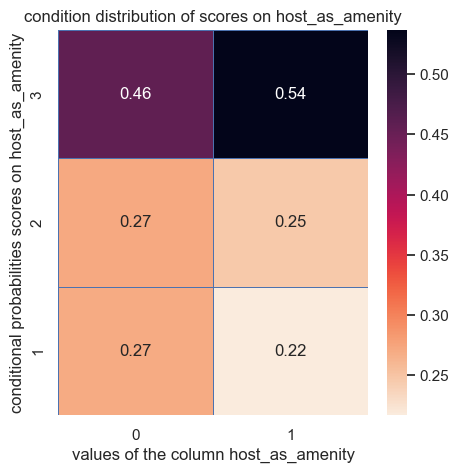

In [460]:
visualize_cond_prob(data=df, target='scores', hue='host_as_amenity')

## Numerical columns

In [461]:
# let's first the describe method for a general overview
df[num_cols].describe()

,shopping_count,acceptance_rate,listing_id,price,tourism_count,latitude,minimum_nights,sustenance_area,maximum_nights,safety_area,financial_area,sustenance_count,ls_count,tourism_area,res_rate,longitude,shopping_area,financial_count,transport_area,entertainment_area
count,213238.000000,213238.000000,2.132380e+05,213238.000000,213238.000000,162476.000000,213238.000000,213238.000000,213238.000000,213238.000000,213238.000000,213238.000000,213238.000000,213238.000000,213238.000000,135962.000000,213238.000000,213238.000000,213238.000000,213238.000000
mean,4.684843,1.356323,4.956852e+06,5.558207,4.646084,3.502449,1.821707,5.708809,5.768011,4.932310,4.920537,5.110149,2.018889,6.388071,1.375674,3.765830,4.799993,4.683601,5.061543,4.776478
std,0.090614,0.057473,6.467300e+06,1.107225,0.070946,0.394316,0.584625,1.163833,1.461005,0.936759,0.845415,0.431235,0.731770,2.453724,0.036900,1.157090,0.594680,0.102054,1.382263,0.652603
min,4.605170,1.098612,2.737000e+03,2.708050,4.605170,2.809504,1.386294,4.605170,1.386294,4.605170,4.605170,4.605170,1.098612,4.605170,1.098612,1.658544,4.605170,4.605170,4.605170,4.605170
25%,4.615121,1.353255,6.509800e+05,4.691348,4.605170,3.110377,1.386294,4.605170,4.532599,4.605170,4.605170,4.736198,1.386294,4.605170,1.386294,2.740646,4.605170,4.615121,4.605170,4.605170
50%,4.653960,1.383791,2.138728e+06,5.424950,4.615121,3.777951,1.609438,5.608319,6.220590,4.605170,4.605170,5.036953,1.791759,4.605170,1.386294,3.466502,4.605170,4.644391,4.605170,4.605170
75%,4.727388,1.386294,7.826669e+06,6.401917,4.653960,3.785463,1.791759,6.590835,7.028201,4.605170,4.605170,5.323010,2.302585,8.062011,1.386294,4.763634,4.605170,4.718499,4.605170,4.605170
max,5.159055,1.386294,4.806012e+07,10.819838,5.181784,3.949235,6.220590,10.011884,20.723266,12.707744,9.833095,6.575076,5.963579,18.040919,1.386294,5.039149,8.773949,5.225747,12.370338,10.408868


We can see that the number of maximum nights is completely insignficant after a certain threshold. Such value can be determined by inspecting the amenity: 'long term stays allowed'. Let's dive directly into it.

In [462]:
# let's connect the dots
LONG_TERM_ALLOWED = 'long term stays allowed'
def set_long_term(row):
    row['long_term'] = LONG_TERM_ALLOWED in row['final_amenities'] 
    return row
df = df.apply(set_long_term, axis=1)

In [463]:
# let's see the distribution of the values depending on the new boolean field
print(df[df['long_term'] == True].describe()['maximum_nights'])
print(df[df['long_term'] == False].describe()['maximum_nights'])

count    196657.000000
mean          5.922411
std           1.327944
min           3.433987
25%           4.532599
50%           6.910751
75%           7.028201
max          20.723266
Name: maximum_nights, dtype: float64
count    16581.000000
mean         3.936762
std          1.702898
min          1.386294
25%          2.833213
50%          3.178054
75%          5.209486
max          7.028201
Name: maximum_nights, dtype: float64


The number of maximum nights are not quite informative for the very simple reason that a client would choose to book the listing only if their stay aligns with the indiciated range.

In [464]:
# time to drop the unnecessary columns
df.drop(columns=['maximum_nights', 'minimum_nights', 'long_term'], inplace=True)

In [ ]:
assert len(df) >= 200000
df_mn = df.copy()

### number of listings
The number of listings might or might not be informative. Generally more listings should reflect more host experience. Nevertheless, more listings require more attention, maintenance and efforts from the host. Can we reflect this observation through combining the different features ? 

In [465]:
df.columns

Index(['listing_id', 'host_since', 'res_time', 'res_rate', 'acceptance_rate',
       'superhost', 'ls_count', 'pf', 'identity', 'neighbourhood', 'city',
       'latitude', 'longitude', 'accommodates', 'amenities', 'price',
       'instant_bookable', 'date', 'comments', 'scores', 'h3',
       'entertainment_count', 'entertainment_area', 'financial_count',
       'financial_area', 'sustenance_count', 'sustenance_area',
       'shopping_count', 'shopping_area', 'transport_count', 'transport_area',
       'tourism_count', 'tourism_area', 'safety_count', 'safety_area', 'exp',
       'final_amenities', 'amenities_score', 'host_as_amenity'],
      dtype='object')

# Further Data Analysis

## Host information 
In the rest of the analysis, we will consider only the data with non-missing values

In [466]:
# first let's define variable for each type of columns
HOST_COLS = ['res_rate', 'res_time', 'acceptance_rate', 'superhost', 'pf', 'identity']

In [467]:
# for easier and faster manipulation, we will extract the host-related columns and work with sub-dataframe
host_df = df.loc[:, HOST_COLS]
host_df.head()
# let's add the price of the stay to the temporary dataframe
host_df['scores'] = df['scores'] 

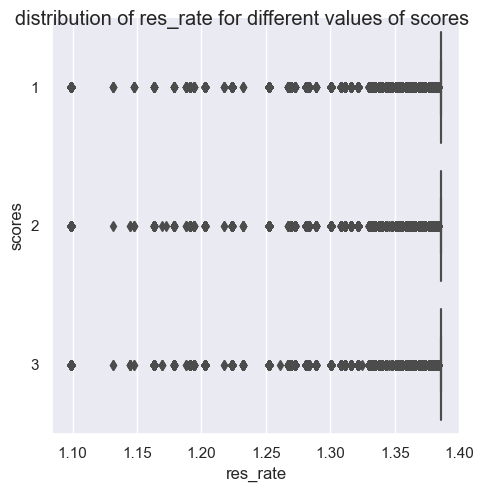

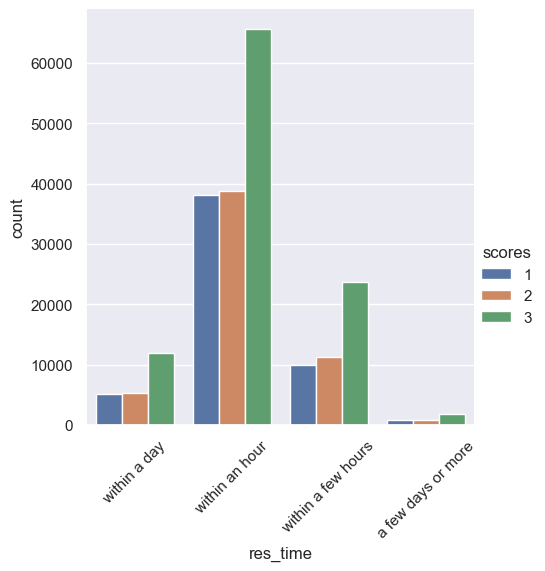

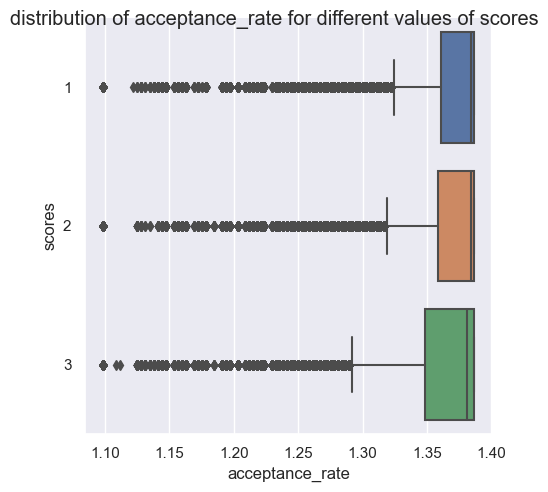

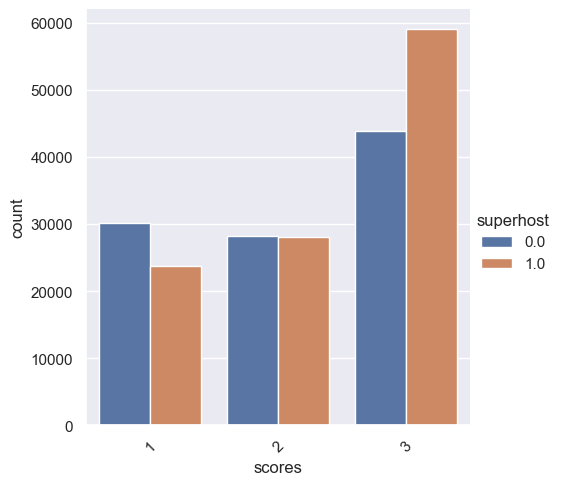

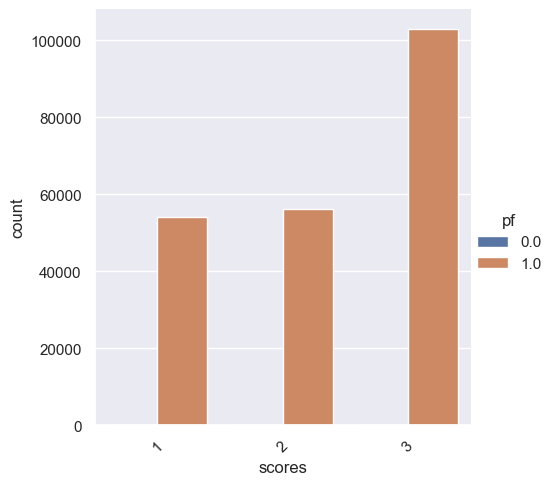

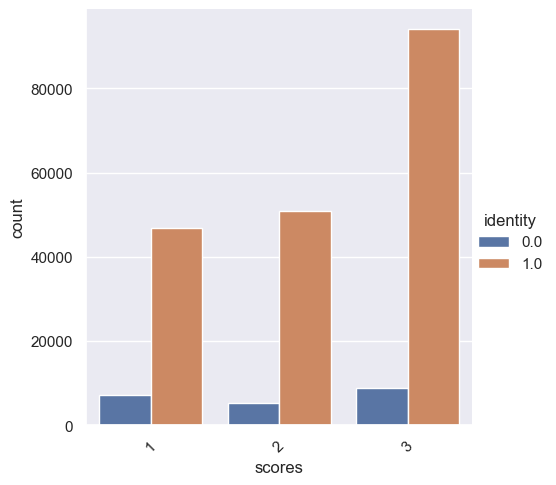

THE CATEGORICAL FEATURE scores or scores HAS TOO MANY CATEGORIES
PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES


In [468]:
# let's see how
visualize_interaction(host_df, feature='scores', use_cols=list(host_df.columns)) 

The visualizations above are quite intriguing as they lead a number of notable observations:
1. The acceptance rate are of little to no importance in the classification
2. More investigation is needed for the response time and response rate
3. The superhost is indeed a very informative feature. A super host rarely offers a negative user-experience
5. The profile picture as well as the identity of the host do not seem to affect the user's experience 


In [469]:
# drop non-needed columns
df.drop(columns=['res_rate', 'acceptance_rate', 'pf'], inplace=True) 

# Geographical location

## City

In [470]:
# even though specifics generally do not hurt, they may distract us from the big picture, the exact coordinates are not needed (at least at this stage)
df.drop(columns=['longitude','latitude'], inplace=True)

Please make sure to input two different categorical columns


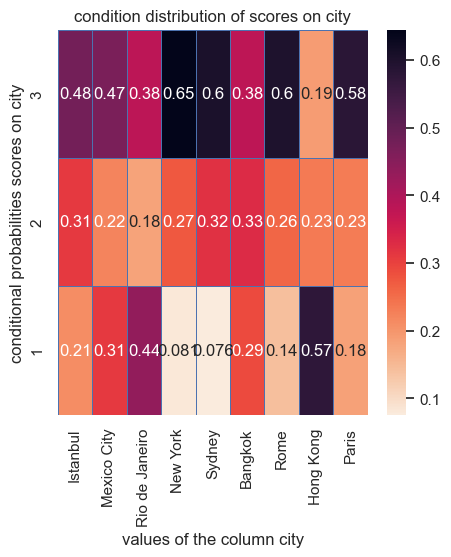

In [471]:
GEO_LOCS = ['neighbourhood', 'city']
# let's consider the conditional probabilities
for g in GEO_LOCS:
    visualize_cond_prob(df, target='scores', hue=g)

Apparently the city with the best user-experiences is Mexico City. On other hand one needs to be a bit more careful when booking a listing in Honk Kong.

## Price

In [472]:
# since the price is expressed in the local currency, it is quite important to express the price in terms of its quantile with respect to all the prices in that country
from empiricaldist import Cdf


def produce_cdfs(df: pd.DataFrame, hue_column: str, target_column: str):
    # the column should represent discrete values too
    counter = Counter()
    for value in df[hue_column].value_counts().index:
        counter[value] = Cdf.from_seq(df[df[hue_column] == value][target_column].tolist())
    return counter

PRICE_BY_CITY_CDFS = produce_cdfs(df, hue_column='city', target_column='price')


In [473]:
def convert_price(row):
    # extract the corresponding cfd
    cdf = PRICE_BY_CITY_CDFS[row['city']]
    row['price_relative'] = round(cdf.forward(row['price']) * 100, 2) # convert the probability to percentage
    return row

df = df.apply(convert_price, axis=1)

In [474]:
# let's consider the linear correlation between the price and the target variable
df[['price', 'price_relative', 'scores']].corr()
# the idea introduced some improvement, but not a significant one.

,price,price_relative,scores
price,1.000000,0.564091,-0.105319
price_relative,0.564091,1.000000,0.101187
scores,-0.105319,0.101187,1.000000


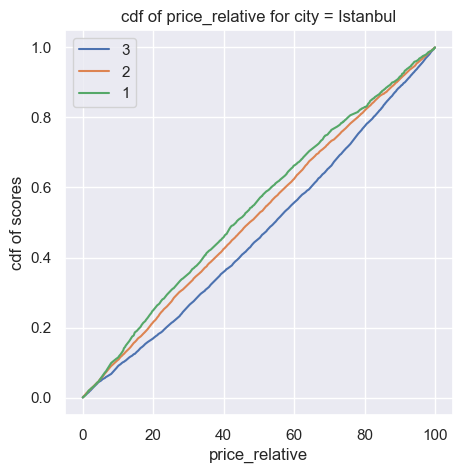

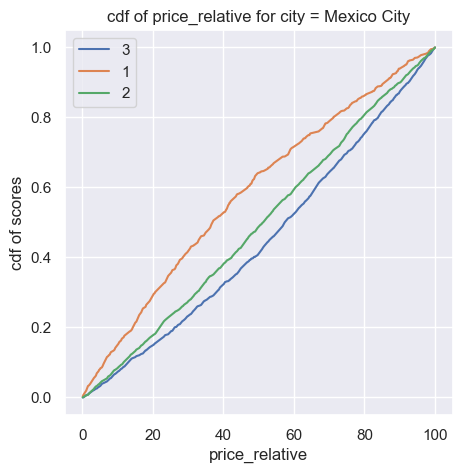

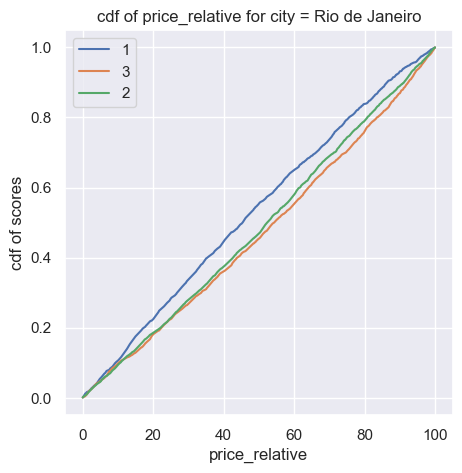

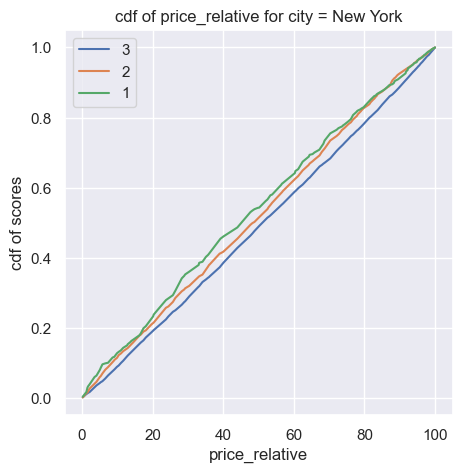

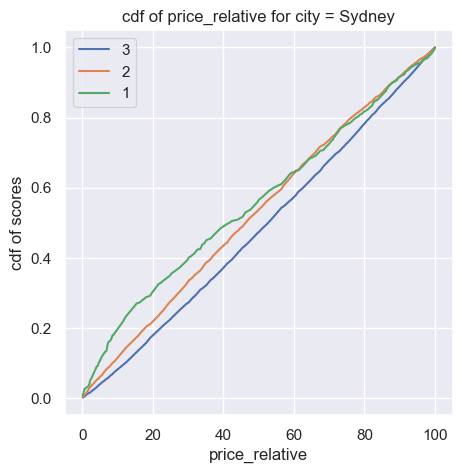

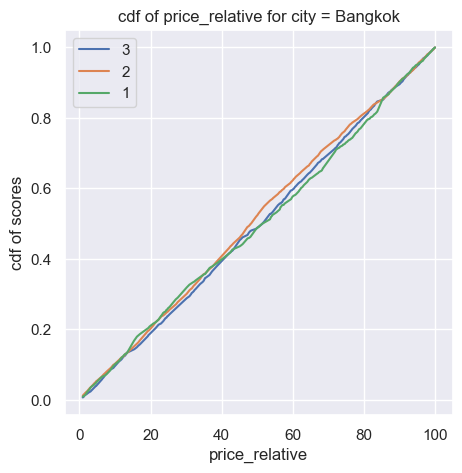

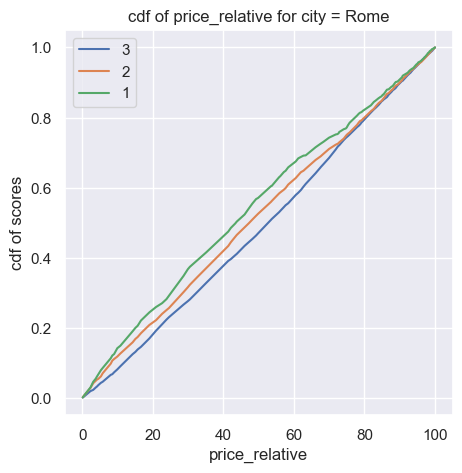

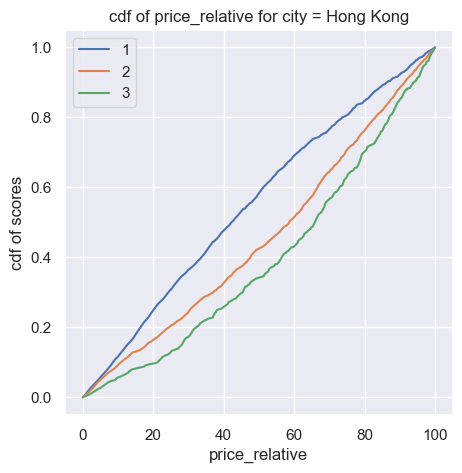

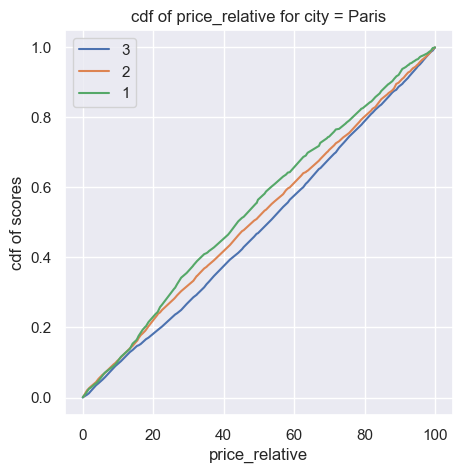

In [475]:
# it seems that the relative place alone is not very informative, let's explore how it varies from one country (city) to another
for city in df['city'].value_counts().index:
    city_data = df[df['city'] == city]
    visualize_num_cat(data=city_data, num_feat='price_relative', cat_feat='scores', num_cat='cdf', title=f'cdf of price_relative for city = {city}')

The price is most influential in **HONG KONG**. Nevertheless, It is of relatively limited effect: it has almost no interaction with the dependent variable in the case of **RIO DE JANEIRO**

## City and Neighbourhodd

In [476]:
N = 'neighbourhood' 
# let's display the number of unique neighborhoods in each city
pd.pivot_table(data=df, index='city', values=N, aggfunc=lambda x: len(x.value_counts()))

,neighbourhood
city,
Bangkok,37
Hong Kong,17
Istanbul,27
Mexico City,12
New York,81
Paris,20
Rio de Janeiro,37
Rome,15
Sydney,35


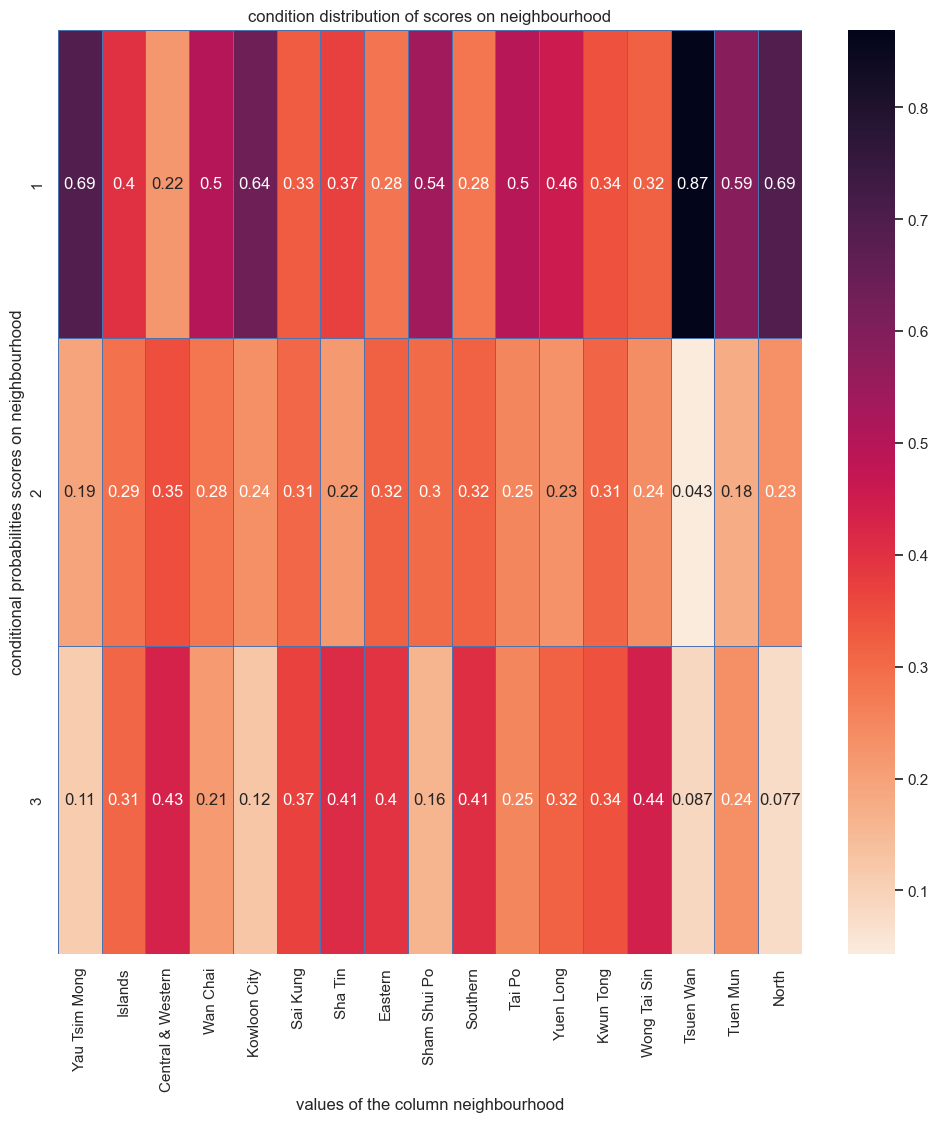

In [477]:
# let's have a random sample of neighbourhoods and see if we can apply some feature enginnering
sns.set(rc={"figure.figsize":(12, 12)})
visualize_cond_prob(df[df['city'] == 'Hong Kong'], target='scores', hue=N)

In [478]:
# it seems that the neighborhood information is quite valuable
# create a dictionary to map each value

n_counter = Counter()
for city in df['city'].value_counts().index:
    df_city =  df[df['city'] == city]
    # iterate through each neighbourhood in this temporary dataframe
    for n in df_city[N].value_counts().index:
        total = len(df_city[df_city[N] == n])
        neg = len(df_city[(df_city[N] == n) & (df_city['scores'] == True)])
        n_counter.update({n: 1 - (neg / total)})

def set_N(row):
    row['N'] = n_counter[row[N]]
    return row

df = df.apply(set_N, axis=1)

In [479]:
# let's convert the cities to numerical representations
city_counter = Counter()
for city in df['city'].value_counts().index:
    city_num = len(df[df['city'] == city])
    nen_city = len(df[(df['city'] == city) & (df['scores'] == 1)])
    city_counter.update({city: 1 - (nen_city / city_num)})

def set_city(row):
    row['city_num'] = city_counter[row['city']]
    return row
df = df.apply(set_city, axis=1)

In [480]:
print(df[['N', 'scores', 'city_num']].corr())

                 N    scores  city_num
N         1.000000  0.385514  0.867154
scores    0.385514  1.000000  0.336261
city_num  0.867154  0.336261  1.000000


THE EXACT NEIGHBOURHOOD PROVIDES RELATIVELY MORE INFORMATION THAN THE CITY IN GENERAL. (THE NUMERICAL REPRESENTATION STILL NEEDS TO BE IMPROVED HOWEVER).

In [481]:
# drop the unused features
df.drop(columns=[N,'final_amenities', 'amenities', 'city', 'price'], inplace=True)

In [482]:
res_times = df['res_time'].value_counts().index.tolist()
res_times
# let's convert the numbers 
res_times_counter = Counter()

for r in res_times:
    res_times_counter.update({r:len(df[df['res_time'] == r]) / len(df)})

res_times_freqs = list(res_times_counter.values())

freqs = list(np.cumsum(res_times_freqs))
freqs.insert(0, 0)
for r_t, f in zip(res_times, freqs[:-1]):
    res_times_counter[r_t] = round(f, 2)

In [483]:
def set_res_time(row):
    row['res_time'] = res_times_counter[row['res_time']]
    return row
df = df.apply(set_res_time, axis=1)
df.dropna(inplace=True)

In [ ]:
# df = df_f.copy()

In [526]:
# df_f = df.copy()
df = df_f.copy()

In [527]:
df.drop(columns =['comments', 'host_since', 'h3', 'listing_id', 'date'], inplace=True)


In [528]:
print(df.dtypes)
data = df.copy()

res_time               float64
superhost              float64
ls_count               float64
identity               float64
accommodates             int64
instant_bookable         int64
scores                   int64
entertainment_count    float64
entertainment_area     float64
financial_count        float64
financial_area         float64
sustenance_count       float64
sustenance_area        float64
shopping_count         float64
shopping_area          float64
transport_count        float64
transport_area         float64
tourism_count          float64
tourism_area           float64
safety_count           float64
safety_area            float64
exp                    float64
amenities_score        float64
host_as_amenity          int64
price_relative         float64
N                      float64
city_num               float64
dtype: object


In [536]:
data.dtypes

res_time               float64
superhost              float64
ls_count               float64
identity               float64
accommodates             int64
instant_bookable         int64
scores                   int64
entertainment_count    float64
entertainment_area     float64
financial_count        float64
financial_area         float64
sustenance_count       float64
sustenance_area        float64
shopping_count         float64
shopping_area          float64
transport_count        float64
transport_area         float64
tourism_count          float64
tourism_area           float64
safety_count           float64
safety_area            float64
exp                    float64
amenities_score        float64
host_as_amenity          int64
price_relative         float64
N                      float64
city_num               float64
dtype: object

In [537]:
df[new_cols + ['scores']].corr()['scores']

entertainment_count    0.066011
entertainment_area    -0.003293
financial_count        0.048294
financial_area         0.024270
sustenance_count       0.144367
sustenance_area        0.087165
shopping_count         0.128986
shopping_area          0.039968
transport_count        0.057221
transport_area         0.005525
tourism_count          0.074021
tourism_area           0.072488
safety_count           0.026205
safety_area            0.036143
scores                 1.000000
Name: scores, dtype: float64

In [538]:
len(data)
data.isna().sum().sum()

0

OUR DATA IS NOW READY FOR MODELING.

# Modeling: Random Forest

In [539]:
X = data.copy()
y = X.pop('scores')

In [540]:
# first let's split the data into 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

TAKING INTO ACCOUNT THE NATURE OF OUR DATA:
1. non-linear relation between the dependent variables and target variable
2. absence of normal distributions of features

Using linear models such as Logistic Regression, SVM is not the best option. On the other hand, "Random Forests" is quite powerful models that does not make any assumptions on the data. Additionally, it is characterized with low bias and lower variance than Decision Trees so overfitting is less likely. Additionally, the model is interpretable which is significant in a business context.

In [541]:
trained = False

In [559]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV


params = {"max_depth": range(4, 7), "n_estimators": np.linspace(150, 200, 4).astype(int), 'min_samples_leaf': np.linspace(0.01, 0.05, 5), "max_features": np.linspace(0.2, 0.8, 3)}
print(params)

if not trained:
    # # no need for scaling or normalizing the data !!
    # params = {"max_depth": range(3, 7), "n_estimators": np.linspace(100, 200, 6).astype(int), 'min_samples_leaf': np.linspace(0.01, 0.05, 6), "max_features": np.linspace(0.5, 0.8, 4)}

    print(params)

    # perform cross validation using Grid Serach

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

    # set the random state for reproducibility
    rf_base = RandomForestClassifier(random_state=11)


    from sklearn.metrics import f1_score, balanced_accuracy_score
    from sklearn.model_selection import RandomizedSearchCV
    # hyper tune the model
    hypertune = RandomizedSearchCV(estimator=rf_base, param_distributions=params, n_iter=2, scoring=balanced_accuracy_score, n_jobs=-1, random_state=11, cv=kfold, verbose=2)

    hypertune.fit(X_train, y_train)

{'max_depth': range(4, 7), 'n_estimators': array([150, 166, 183, 200]), 'min_samples_leaf': array([0.01, 0.02, 0.03, 0.04, 0.05]), 'max_features': array([0.2, 0.5, 0.8])}
{'max_depth': range(4, 7), 'n_estimators': array([150, 166, 183, 200]), 'min_samples_leaf': array([0.01, 0.02, 0.03, 0.04, 0.05]), 'max_features': array([0.2, 0.5, 0.8])}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\bouab\DEV\ds_env\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


In [553]:
from joblib import dump, load
if not trained:
    model = hypertune.best_estimator_
else: 
    model = load('airbnb_model.joblib')
# time to retrain the model on the entire dataset
model.fit(X_train, y_train)
# now time to predict on the test dataset
y_pred = model.predict(X_test)

dump(model, 'airbnb_model.joblib')


In [557]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.4521209803679702

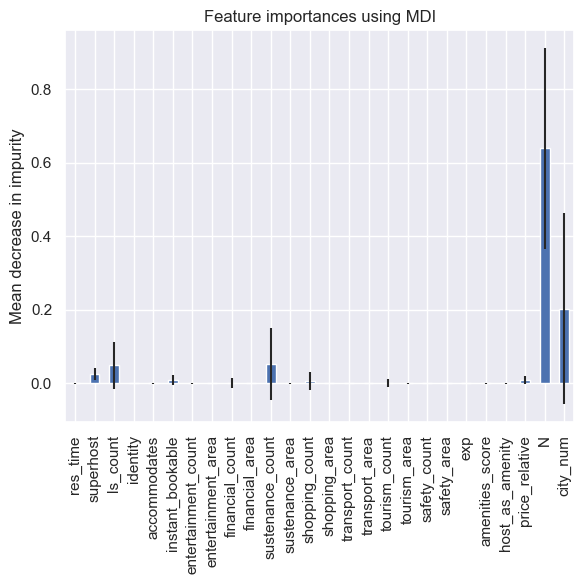

In [558]:
sns.set(rc={"figure.figsize":(6, 6)})

importances = model.feature_importances_

forest_importances = pd.Series(importances, index=X.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [560]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.52      0.49      0.51     10803
           2       0.00      0.00      0.00     11243
           3       0.55      0.87      0.67     20597

    accuracy                           0.54     42643
   macro avg       0.36      0.45      0.39     42643
weighted avg       0.40      0.54      0.45     42643



c:\Users\bouab\DEV\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bouab\DEV\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bouab\DEV\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
